In [1]:
from iterdub import iterdub as ib
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
import matplotlib
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import pathlib
from scipy import stats
import seaborn as sns
from slugify import slugify
import statsmodels.api as sm
import statsmodels.formula.api as smf
from teeplot import teeplot as tp

In [2]:
from conduitpylib.utils import consolidate_merge

In [3]:
nbm.print_metadata()

context: ci
hostname: f6a869f4a334
interpreter: 3.6.5 (default, Apr  1 2018, 05:46:30)  [GCC 7.3.0]
nbcellexec: 3
nbname: a=weak-scaling+compute-work=0+simels_per_cpu=1_2048+ext=
nbpath: /opt/conduit/binder/date=2021+project=72k5n/a=weak-scaling/a=weak-scaling+compute-work=0+simels_per_cpu=1_2048+ext=.ipynb
revision: null
session: 425b0a2b-ea78-4b3a-ae07-5baf995ec230
timestamp: 2021-09-15T03:58:30Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.4.1
iterdub==0.2.0
iterpop==0.3.4
matplotlib==3.3.2
nbmetalog==0.2.4
numpy==1.19.5
pandas==1.1.2
scipy==1.5.4
seaborn==0.11.0
statsmodels==0.12.2
teeplot==0.2.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data

In [4]:
df_inlet = pd.read_csv(
    'https://osf.io/2rdj6/download',
    compression='gzip',
).dropna(
    subset=['Process Instance UUID'],
)
nbm.print_dataframe_summary(*eval(nbm.nvp_expr(
    'df_inlet'
)))

a: df_inlet
digest: 2f18ab681bace3cfecbca30bd7af39924b364f5f73a1768798b4e0a4aab31426
num cols: 69
num cols all na: 6
num cols any na: 22
num na: 1054851
num rows: 175232
num rows all na: 0
num rows any na: 175232
size: 178M



In [5]:
df_outlet = pd.read_csv(
    'https://osf.io/9utpr/download',
    compression='gzip',
).dropna(
    subset=['Process Instance UUID'],
)
nbm.print_dataframe_summary(*eval(nbm.nvp_expr(
    'df_outlet'
)))

a: df_outlet
digest: 0ed4c9412242f96fb60705047712f0b6590bedb3085d3228d84a4eb79472a0bc
num cols: 43
num cols all na: 2
num cols any na: 12
num na: 352790
num rows: 175232
num rows all na: 0
num rows any na: 175232
size: 143M



In [6]:
df = consolidate_merge(
    df_inlet,
    df_outlet,
    on=['Process Instance UUID', 'Update'],
    suffixes=(' Inlet', ' Outlet'),
    how='outer',
)
nbm.print_dataframe_synopsis(*eval(nbm.nvp_expr(
    'df'
)))

a: df
digest: 87ce39c408554af50f4379de5f0160ed99dc29392e94fd8f6280640d20503662
manifest:
- Row Initial Timepoint (ns) Inlet
- Num Outlets
- Num Reads Performed
- Num Reads That Were Fresh
- Num Reads That Were Stale
- Num Revisions Pulled
- Net Flux Through Duct
- Num Try Pulls Attempted
- Num Try Pulls That Were Laden
- Num Blocking Pulls
- Num Blocking Pulls That Blocked
- Num Revisions From Try Pulls
- Num Revisions From Blocking Pulls
- Num Pulls Attempted
- Num Round Trip Touches Inlet
- Num Pulls That Were Laden Eventually
- Num Blocking Pulls That Were Laden Immediately
- Num Blocking Pulls That Were Laden Eventually
- Num Pulls That Were Laden Immediately
- Num Try Pulls That Were Unladen
- Fraction Try Pulls That Were Laden
- Fraction Try Pulls That Were Unladen
- Fraction Blocking Pulls That Blocked
- Fraction Blocking Pulls That Were Laden Immediately
- Fraction Blocking Pulls That Were Laden Eventually
- Fraction Pulls That Were Laden Immediately
- Fraction Pulls That Were 

# Prep Data

In [7]:
df = df.astype({
    'Num Inlets' : 'int64',
    'Num Outlets' : 'int64',
    'Num Puts Attempted' : 'int64',
    'Num Try Puts Attempted' : 'int64',
    'Num Blocking Puts' : 'int64',
    'Num Try Puts That Succeeded' : 'int64',
    'Num Puts That Succeeded Eventually' : 'int64',
    'Num Blocking Puts That Succeeded Immediately' : 'int64',
    'Num Puts That Succeeded Immediately' : 'int64',
    'Num Puts That Blocked' : 'int64',
    'Num Dropped Puts' : 'int64',
    'Num Round Trip Touches Inlet' : 'int64',
    'Net Flux Through Duct' : 'int64',
    'proc' : 'int64',
    'Snapshot' : 'int64',
    'Has Execution Blur' : 'bool',
    'Replicate' : 'int64',
    'Async Mode' : 'int64',
    'Num Threads' : 'int64',
    'Num Processes' : 'int64',
    'SLURM_NNODES' : 'int64',
    'SLURM_NTASKS' : 'int64',
    'SLURM_CPUS_ON_NODE' : 'int64',
})

In [8]:
df['Hostname'] = df.apply(
    lambda row: kn.unpack(row['Source File Inlet'])['_hostname'],
    axis=1,
)

In [9]:
df['Num Nodes'] = df['SLURM_NNODES']
df['Num Tasks'] = df['SLURM_NTASKS']
df['Num Simels Per Cpu'] = df['Num Simulation Elements Per Cpu']
df['Num Cpus'] = df['Num Threads'] * df['Num Processes']
df['Allocated Tasks Per Node'] = df['Num Tasks'] // df['Num Nodes']
df['Cpus Per Node'] = df['Allocated Tasks Per Node']
df['Delivery Time Inlet'] = (df['Num Puts Attempted'] - 1) / df['Num Round Trip Touches Inlet']
df['Delivery Time Outlet'] = (df['Num Pulls Attempted'] - 1) / df['Num Round Trip Touches Outlet']
df['Intermittancy'] = df['Num Pulls That Were Laden Immediately'] / df[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df['Inlet-Seconds Elapsed'] = df['Num Inlets'] * df['Runtime Seconds Elapsed Inlet']
df['Outlet-Seconds Elapsed'] = df['Num Outlets'] * df['Runtime Seconds Elapsed Outlet']
df['Latency Simsteps Inlet'] = df['Delivery Time Inlet']
df['Latency Simsteps Outlet'] = df['Delivery Time Inlet']
df['Simstep Period Inlet (s)'] = df['Inlet-Seconds Elapsed'] / df['Num Puts Attempted']
df['Simstep Period Outlet (s)'] =  df['Outlet-Seconds Elapsed'] / df['Num Pulls Attempted']
df['Latency Walltime Inlet (s)'] = df['Latency Simsteps Inlet'] * df['Simstep Period Inlet (s)']
df['Latency Walltime Outlet (s)'] = df['Latency Simsteps Outlet'] * df['Simstep Period Outlet (s)']
df['Log Num Processes'] = np.log(df['Num Processes']) / np.log(4)

# Prep DataFrame Variants

In [10]:
# https://stackoverflow.com/a/40629420
df_finalized_observations = df.sort_values('Update', ascending=False).drop_duplicates(['Process Instance UUID'])

In [11]:
df_blurry_snapshots = df[
    df['Has Execution Blur'].astype(bool)
    & (df['Snapshot'] <= 5 )
    # exclude excess, unintended snapshots from runs that took a while to shut down
    # (i.e., from at the 6 minute mark and beyond)
]

In [12]:
df_world_sum = df_finalized_observations.groupby([
    'Replicate',
    'Async Mode',
    'Num Processes',
    'Num Nodes',
    'Num Simels Per Cpu',
    'Allocated Tasks Per Node',
    'Cpus Per Node',
],  as_index=False).sum()

df_world_sum['Fraction Messages Utilized'] = df_world_sum['Num Reads That Were Fresh'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Fraction Messages Delivered'] = df_world_sum['Num Try Puts That Succeeded'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Delivery Failure Rate'] = 1.0 - df_world_sum['Fraction Messages Delivered']
df_world_sum['Fraction Messages Dropped'] = df_world_sum['Delivery Failure Rate']
df_world_sum['Fraction Try Pulls That Were Laden'] = df_world_sum['Num Try Pulls That Were Laden'] / df_world_sum['Num Try Pulls Attempted']
df_world_sum['Round Trip Touches Per Attempted Pull'] = df_world_sum['Num Round Trip Touches Outlet'] / df_world_sum['Num Try Pulls Attempted']
df_world_sum['Round Trip Touches Per Attempted Put'] = df_world_sum['Num Round Trip Touches Inlet'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Num Inflight Messages'] = 2.0 / df_world_sum['Round Trip Touches Per Attempted Put'] - 1
df_world_sum['Fraction Duct Flux Stepped Through'] = df_world_sum['Num Revisions Pulled'] / df_world_sum['Net Flux Through Duct']
df_world_sum['Fraction Duct Flux Jumped Over'] = 1.0 - df_world_sum['Fraction Duct Flux Stepped Through']
df_world_sum['Round Trip Touches Per Runtime Second'] = df_world_sum['Num Round Trip Touches Inlet'] / df_world_sum['Runtime Seconds Elapsed Inlet']
df_world_sum['Latency Simsteps Inlet'] = (df_world_sum['Num Puts Attempted'] - 1) / df_world_sum['Num Round Trip Touches Inlet']
df_world_sum['Latency Simsteps Outlet'] = (df_world_sum['Num Pulls Attempted'] - 1) / df_world_sum['Num Round Trip Touches Outlet']
df_world_sum['Delivery Clumpiness'] = 1.0 - df_world_sum['Num Pulls That Were Laden Immediately'] / df_world_sum[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df_world_sum['Intermittancy'] = df_world_sum['Delivery Clumpiness']
df_world_sum['Simstep Period Inlet (s)'] = df_world_sum['Inlet-Seconds Elapsed'] / df_world_sum['Num Puts Attempted']
df_world_sum['Simstep Period Outlet (s)'] = df_world_sum['Outlet-Seconds Elapsed'] / df_world_sum['Num Pulls Attempted']
df_world_sum['Latency Walltime Inlet (s)'] = df_world_sum['Latency Simsteps Inlet'] * df_world_sum['Simstep Period Inlet (s)']
df_world_sum['Latency Walltime Outlet (s)'] = df_world_sum['Latency Simsteps Outlet'] * df_world_sum['Simstep Period Outlet (s)']

In [13]:
df_snapshot_diffs = df_blurry_snapshots.groupby(
    [
        'Process Instance UUID',
        'Snapshot',
        # subsequent items aren't meaningful to groupby
        # but are just included so they pass through untouched
        'Async Mode',
        'Num Nodes',
        'Allocated Tasks Per Node',
        'Cpus Per Node',
        'Num Processes',
        'Log Num Processes',
        'Num Simels Per Cpu',
        'Replicate',
        'proc',
        'Hostname',
        'Num Inlets',
        'Num Outlets',
        'Execution Instance UUID',
        'Num Threads',
    ],
    as_index=False,
).aggregate({
    'Num Puts Attempted' : np.ptp,
    'Num Try Puts Attempted' : np.ptp,
    'Num Blocking Puts'  : np.ptp,
    'Num Try Puts That Succeeded' : np.ptp,
    'Num Puts That Succeeded Eventually' : np.ptp,
    'Num Blocking Puts That Succeeded Immediately' : np.ptp,
    'Num Puts That Succeeded Immediately' : np.ptp,
    'Num Puts That Blocked' : np.ptp,
    'Num Dropped Puts' : np.ptp,
    'Num Reads Performed' : np.ptp,
    'Num Reads That Were Fresh' : np.ptp,
    'Num Reads That Were Stale' : np.ptp,
    'Num Revisions Pulled' : np.ptp,
    'Num Try Pulls Attempted' : np.ptp,
    'Num Blocking Pulls' : np.ptp,
    'Num Blocking Pulls That Blocked' : np.ptp,
    'Num Revisions From Try Pulls' : np.ptp,
    'Num Revisions From Blocking Pulls' : np.ptp,
    'Num Pulls Attempted' : np.ptp,
    'Num Pulls That Were Laden Eventually' : np.ptp,
    'Num Blocking Pulls That Were Laden Immediately' : np.ptp,
    'Num Blocking Pulls That Were Laden Eventually' : np.ptp,
    'Num Pulls That Were Laden Immediately' : np.ptp,
    'Num Try Pulls That Were Laden' : np.ptp,
    'Num Try Pulls That Were Unladen' : np.ptp,
    'Net Flux Through Duct' : np.ptp,
    'Num Round Trip Touches Inlet' : np.ptp,
    'Num Round Trip Touches Outlet' : np.ptp,
# why are these missing?
#     'Row Initial Timepoint (ns) Inlet' : np.ptp,
#     'Row Initial Timepoint (ns) Outlet' : np.ptp,
    'Row Final Timepoint (ns) Inlet' : np.ptp,
    'Row Final Timepoint (ns) Outlet' : np.ptp,
    'Runtime Seconds Elapsed Inlet' : np.mean,
    'Runtime Seconds Elapsed Outlet' : np.mean,
})

In [14]:
df_snapshot_diffs['Fraction Messages Delivered'] = (
    df_snapshot_diffs['Num Try Puts That Succeeded']
    / df_snapshot_diffs['Num Try Puts Attempted']
)
df_snapshot_diffs['Delivery Success Rate'] = (
    df_snapshot_diffs['Num Try Puts That Succeeded']
    / df_snapshot_diffs['Num Try Puts Attempted']
)
df_snapshot_diffs['Delivery Failure Rate'] = 1 - df_snapshot_diffs['Delivery Success Rate']
df_snapshot_diffs['Fraction Messages Dropped'] = df_snapshot_diffs['Delivery Failure Rate']
df_snapshot_diffs['Fraction Try Pulls That Were Laden'] = (
    df_snapshot_diffs['Num Try Pulls That Were Laden']
    / df_snapshot_diffs['Num Try Pulls Attempted']
)

df_snapshot_diffs['Round Trip Touches Per Attempted Put'] = (
    df_snapshot_diffs['Num Round Trip Touches Inlet']
) / df_snapshot_diffs['Num Try Puts Attempted']

df_snapshot_diffs['Round Trip Touches Per Attempted Pull'] = (
    df_snapshot_diffs['Num Round Trip Touches Outlet']
) / df_snapshot_diffs['Num Try Pulls Attempted']

df_snapshot_diffs['Round Trip Touches Per Runtime Nanosecond'] = (
    df_snapshot_diffs['Num Round Trip Touches Outlet']
) / df_snapshot_diffs['Row Final Timepoint (ns) Outlet']

df_snapshot_diffs['Latency Simsteps Inlet'] = df_snapshot_diffs['Num Puts Attempted'] / df_snapshot_diffs['Num Round Trip Touches Inlet']
df_snapshot_diffs['Latency Simsteps Outlet'] = df_snapshot_diffs['Num Pulls Attempted'] / df_snapshot_diffs['Num Round Trip Touches Outlet']
df_snapshot_diffs['Delivery Clumpiness'] = 1.0 - df_snapshot_diffs['Num Pulls That Were Laden Immediately'] / df_snapshot_diffs[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df_snapshot_diffs['Intermittancy'] = df_snapshot_diffs['Delivery Clumpiness']
df_snapshot_diffs['Inlet-Nanoseconds Elapsed'] = df_snapshot_diffs['Num Inlets'] * df_snapshot_diffs['Row Final Timepoint (ns) Inlet']
df_snapshot_diffs['Outlet-Nanoseconds Elapsed'] = df_snapshot_diffs['Num Outlets'] * df_snapshot_diffs['Row Final Timepoint (ns) Outlet']
df_snapshot_diffs['Simsteps Elapsed Inlet'] = df_snapshot_diffs['Num Puts Attempted'] / df_snapshot_diffs['Num Inlets']
df_snapshot_diffs['Simsteps Elapsed Outlet'] = df_snapshot_diffs['Num Pulls Attempted'] / df_snapshot_diffs['Num Outlets']
df_snapshot_diffs['Simstep Period Inlet (ns)'] = df_snapshot_diffs['Inlet-Nanoseconds Elapsed'] / df_snapshot_diffs['Num Puts Attempted']
df_snapshot_diffs['Simstep Period Outlet (ns)'] = df_snapshot_diffs['Outlet-Nanoseconds Elapsed'] / df_snapshot_diffs['Num Pulls Attempted']
df_snapshot_diffs['Latency Walltime Inlet (ns)'] = df_snapshot_diffs['Latency Simsteps Inlet'] * df_snapshot_diffs['Simstep Period Inlet (ns)']
df_snapshot_diffs['Latency Walltime Outlet (ns)'] = df_snapshot_diffs['Latency Simsteps Outlet'] * df_snapshot_diffs['Simstep Period Outlet (ns)']

In [15]:
df_snapshot_diffs = df_snapshot_diffs.astype({
    'Num Inlets' : 'int64',
    'Num Outlets' : 'int64',
    'proc' : 'int64',
    'Snapshot' : 'int64',
    'Replicate' : 'int64',
    'Async Mode' : 'int64',
    'Num Threads' : 'int64',
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Nodes' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

# End-state Data Analysis

This data appears to be skewed by ragged network launch/completion.

In [16]:
def facet_boxplot(*, data, col, row, x, y, showfliers=False):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.boxplot,
        x,
        y,
        showfliers=showfliers,
    )

## Latency Walltime

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-inlet-s+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-inlet-s+ext=.png


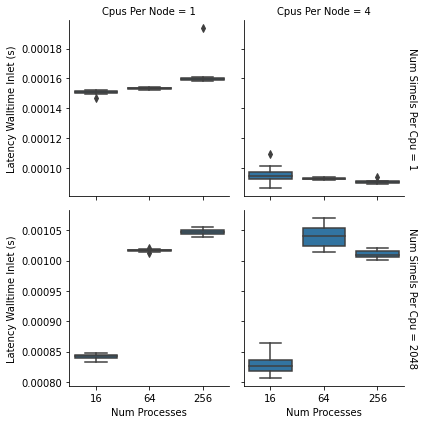

In [17]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Latency Walltime Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-outlet-s+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-outlet-s+ext=.png


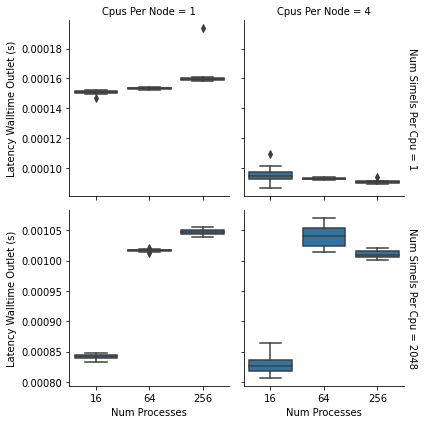

In [18]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Latency Walltime Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

## Latency Simsteps

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-inlet+ext=.png


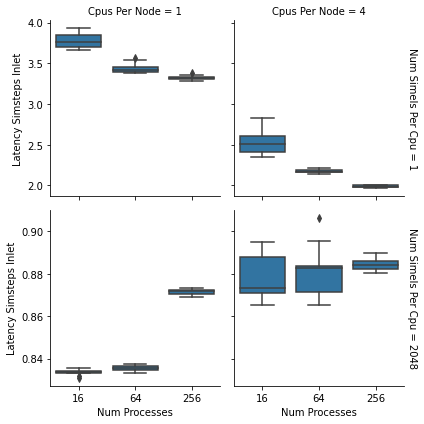

In [19]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Latency Simsteps Inlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-outlet+ext=.png


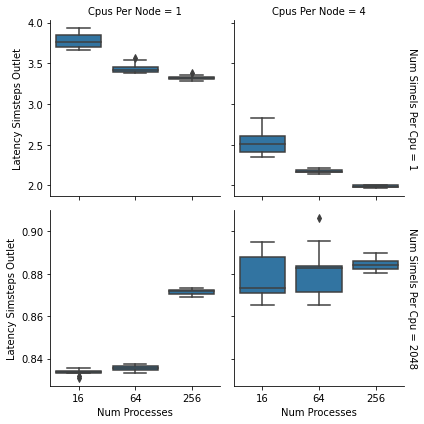

In [20]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Latency Simsteps Outlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

## Delivery Failure Rate

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-failure-rate+ext=.png


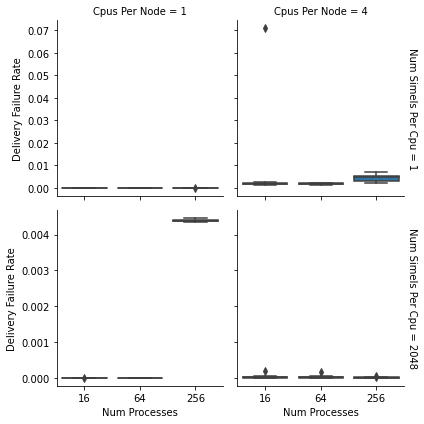

In [21]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Delivery Failure Rate',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

## Delivery Clumpiness

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-clumpiness+ext=.png


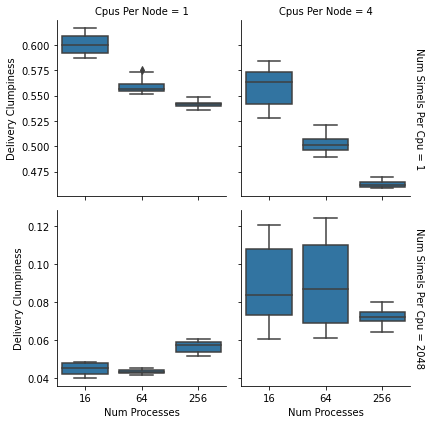

In [22]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Delivery Clumpiness',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

## Simstep Period

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-inlet-s+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-inlet-s+ext=.png


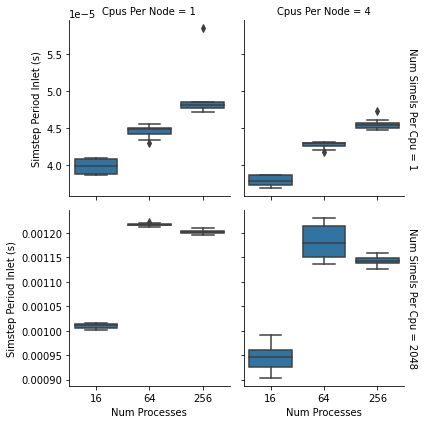

In [23]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Simstep Period Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-outlet-s+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-outlet-s+ext=.png


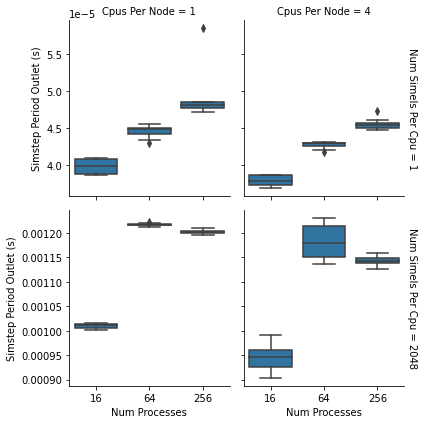

In [24]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    col='Cpus Per Node',
    row='Num Simels Per Cpu',
    x='Num Processes',
    y='Simstep Period Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
)

# Live Snapshot Analysis

In [25]:
def facet_barplot(*, data, col, row, x, y, hue=None):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.barplot,
        x=x,
        y=y,
        hue=hue,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

In [26]:
def facet_boxplot_withfliers(*, data, col, row, x, y, hue=None):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.boxplot,
        x=x,
        y=y,
        hue=hue,
        showfliers=True,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

In [27]:
def facet_boxplot_nofliers(*, data, col, row, x, y, hue=None):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.boxplot,
        x=x,
        y=y,
        hue=hue,
        showfliers=False,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

## Latency Walltime

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-walltime-inlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-walltime-inlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-walltime-inlet-ns+ext=.png


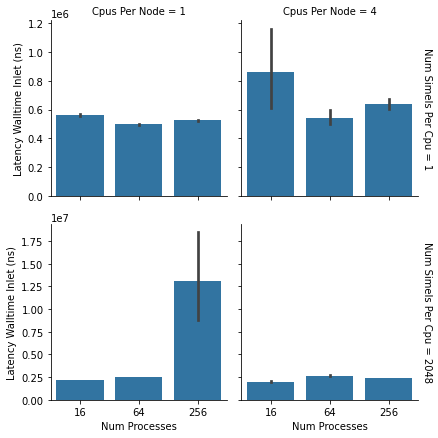

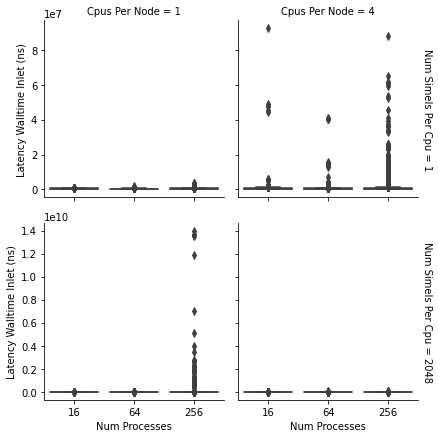

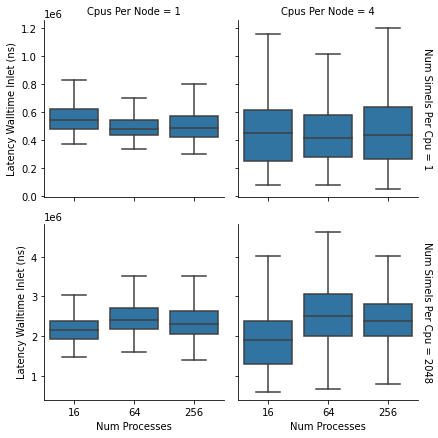

In [28]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Latency Walltime Inlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-walltime-outlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-walltime-outlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-walltime-outlet-ns+ext=.png


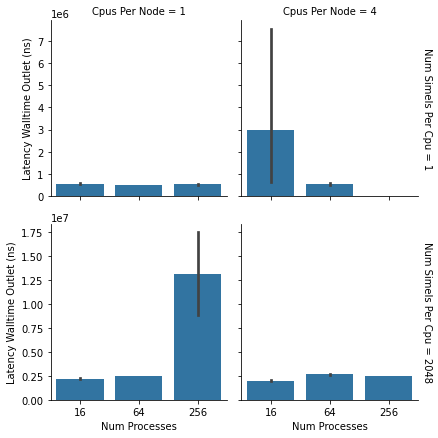

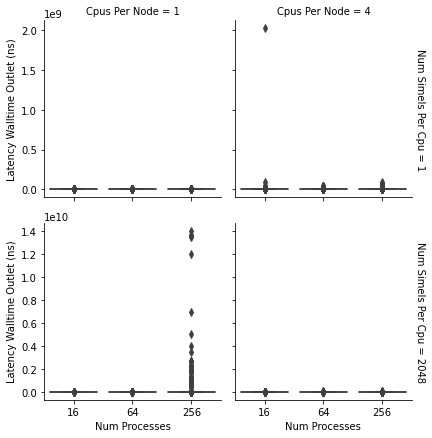

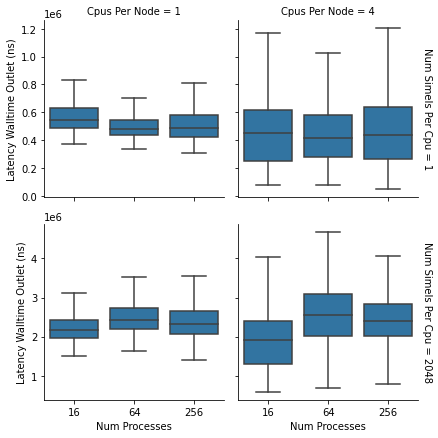

In [29]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Latency Walltime Outlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

## Latency Simsteps

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-simsteps-inlet+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-simsteps-inlet+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-simsteps-inlet+ext=.png


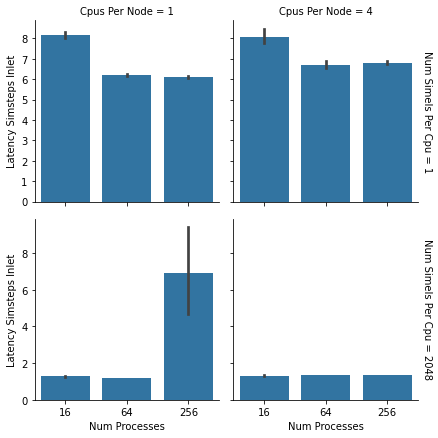

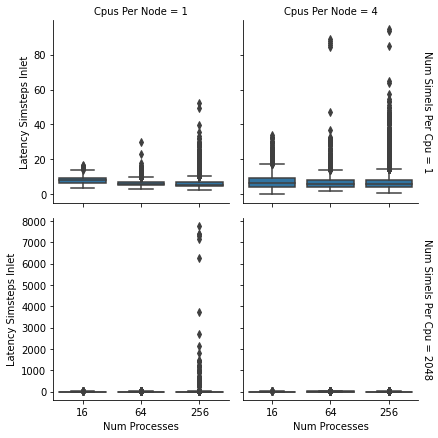

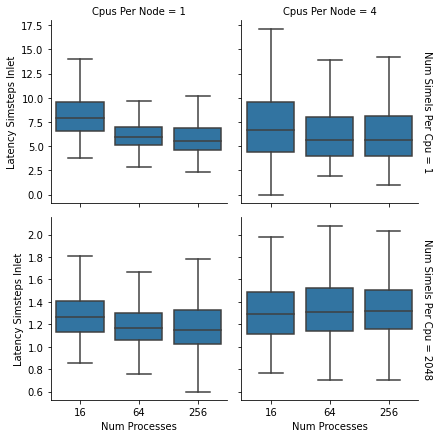

In [30]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Latency Simsteps Inlet',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=latency-simsteps-outlet+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=latency-simsteps-outlet+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=latency-simsteps-outlet+ext=.png


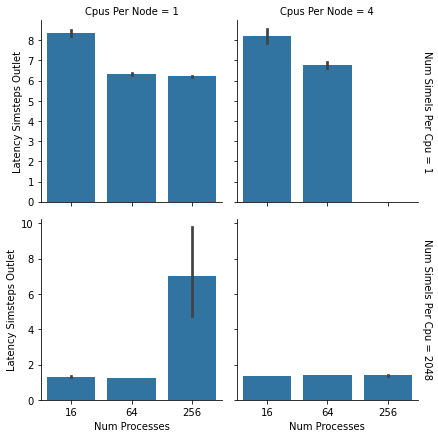

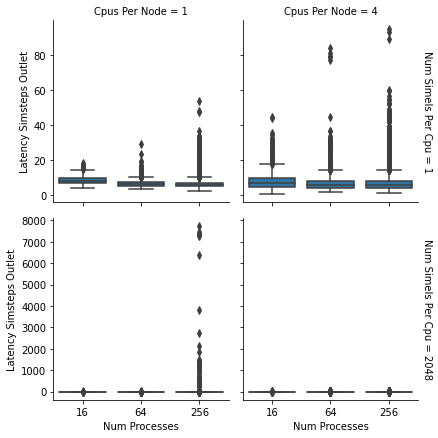

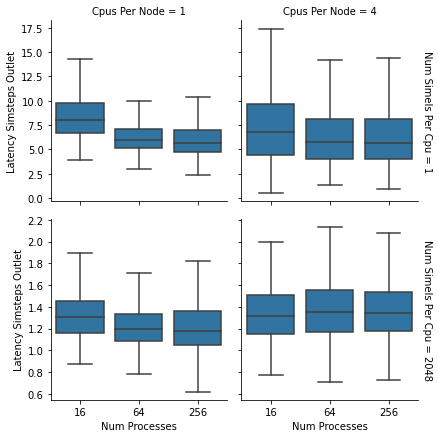

In [31]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Latency Simsteps Outlet',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

## Delivery Failure Rate

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=delivery-failure-rate+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=delivery-failure-rate+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=delivery-failure-rate+ext=.png


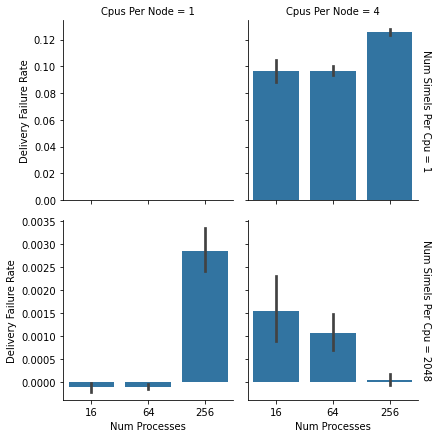

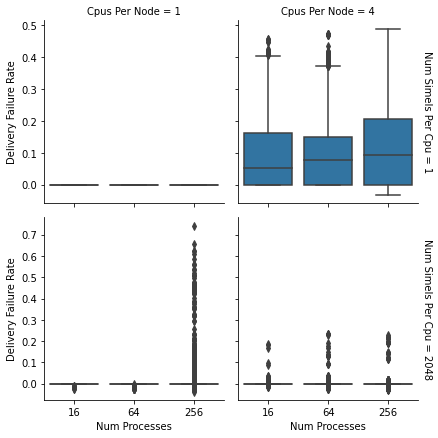

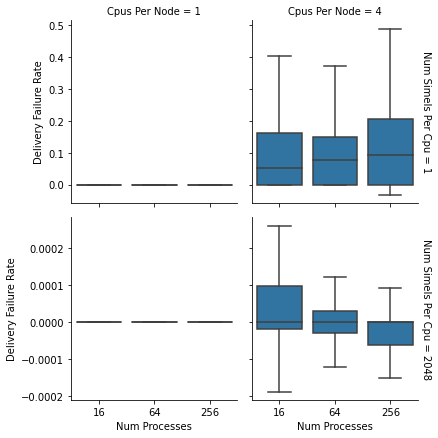

In [32]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Delivery Failure Rate',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

## Delivery Clumpiness

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=delivery-clumpiness+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=delivery-clumpiness+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=delivery-clumpiness+ext=.png


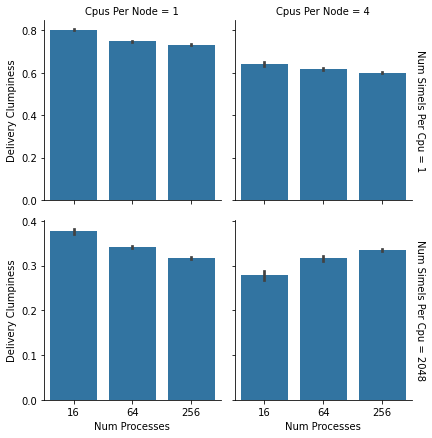

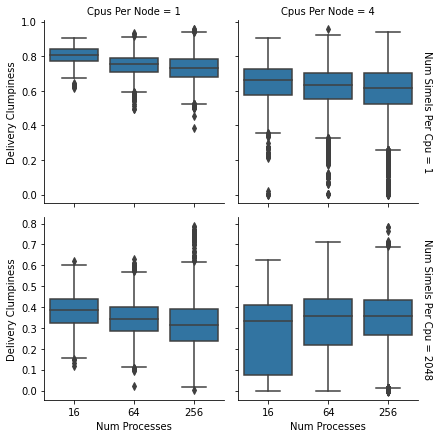

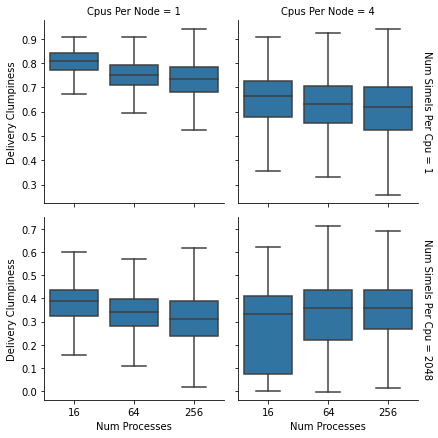

In [33]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Delivery Clumpiness',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

## Simstep Period

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=simstep-period-inlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=simstep-period-inlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=simstep-period-inlet-ns+ext=.png


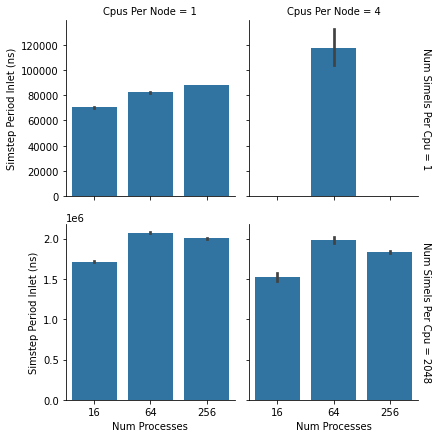

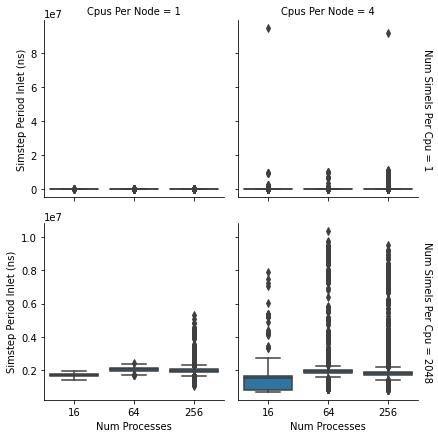

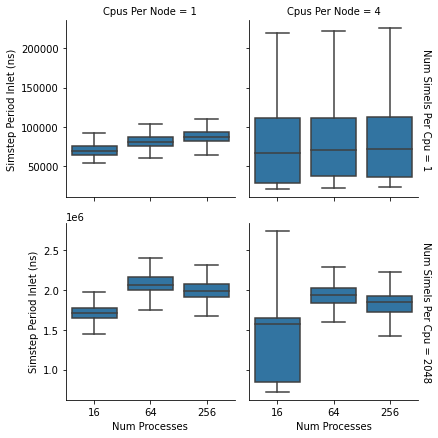

In [34]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Simstep Period Inlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=num-processes+y=simstep-period-outlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=num-processes+y=simstep-period-outlet-ns+ext=.png
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=num-processes+y=simstep-period-outlet-ns+ext=.png


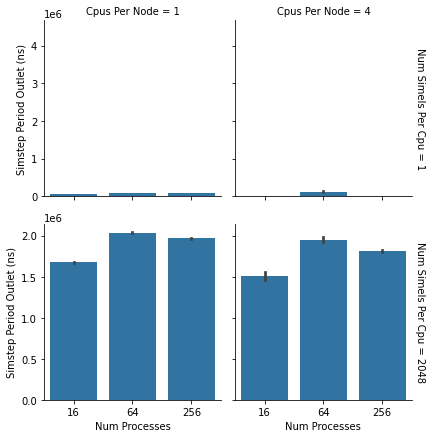

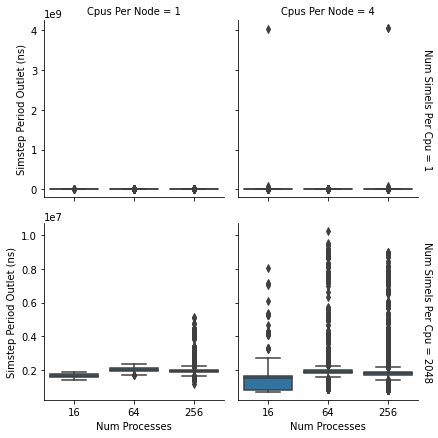

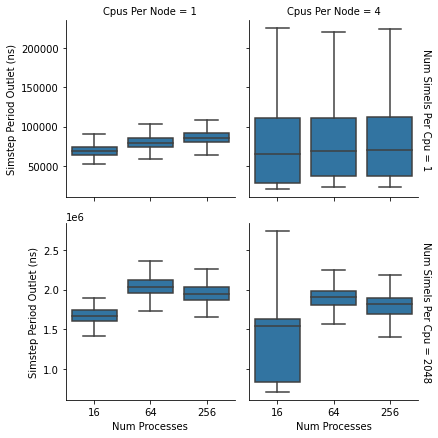

In [35]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Num Processes',
        y='Simstep Period Outlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

# Model Fits

In [36]:
def make_regression_row(*, data, dependent_variable, regression, row_filter):

    filtered_data = data[ data.apply(eval(row_filter), axis=1) ]

    regfun = {
        'Ordinary Least Squares Regression' : smf.ols,
        'Quantile Regression' : smf.quantreg,
    }[regression]
    model = regfun(f"Q('{dependent_variable}') ~ Q('Log Num Processes')", filtered_data)
    fit_model = model.fit()

    slope = fit_model.params["Q('Log Num Processes')"]
    intercept = fit_model.params['Intercept']

    slope_ci_lb, slope_ci_ub = fit_model.conf_int().loc["Q('Log Num Processes')"].tolist()
    intercept_ci_lb, intercept_ci_ub = fit_model.conf_int().loc['Intercept'].tolist()

    p = fit_model.pvalues.loc["Q('Log Num Processes')"]

    # normalize to "control", i.e., lowest num processes observed
    effect_size_normalization_data = data[
        data['Log Num Processes'] == data['Log Num Processes'].min()
    ][dependent_variable]
    effect_size_normalization_factor = {
        'Ordinary Least Squares Regression' : lambda x: x.mean(),
        'Quantile Regression' : lambda x: x.median(),
    }[regression](effect_size_normalization_data)
    relative_effect_size = slope / effect_size_normalization_factor
    relative_effect_size_ci_lb = slope_ci_lb / effect_size_normalization_factor
    relative_effect_size_ci_ub = slope_ci_ub / effect_size_normalization_factor
    relative_effect_size_ci_width = (
        relative_effect_size_ci_ub
        - relative_effect_size_ci_lb
    )

    is_significant = p < 0.05 if np.isfinite(p) else None

    res = {
        'Independent Variable' : 'Log Num Processes',
        'Dependent Variable' : dependent_variable,
        'Dependent Variable Slug' : slugify(dependent_variable),
        'Cpus Per Node' : ip.pophomogeneous( data['Cpus Per Node'] ),
        'Num Simels Per Cpu' : ip.pophomogeneous( data['Num Simels Per Cpu'] ),
        'Slope Estimate' : slope,
        'Slope Estimate 95% CI Lower Bound' : slope_ci_lb,
        'Slope Estimate 95% CI Upper Bound' : slope_ci_ub,
        'Absolute Effect Size' : slope,
        'Absolute Effect Size 95% CI Lower Bound' : slope_ci_lb,
        'Absolute Effect Size 95% CI Upper Bound' : slope_ci_ub,
        'Absolute Effect Size 95% CI Width' : slope_ci_ub - slope_ci_lb,
        'Relative Effect Size' : relative_effect_size,
        'Relative Effect Size 95% CI Lower Bound' : relative_effect_size_ci_lb,
        'Relative Effect Size 95% CI Upper Bound' : relative_effect_size_ci_ub,
        'Relative Effect Size 95% CI Width' : relative_effect_size_ci_width,
        'Intercept Estimate' : intercept,
        'Intercept Estimate 95% CI Lower Bound' : intercept_ci_lb,
        'Intercept Estimate 95% CI Upper Bound' : intercept_ci_ub,
        'R^2' : fit_model.rsquared,
        'p' : fit_model.pvalues.loc["Q('Log Num Processes')"],
        'Significant?' : is_significant,
        'Significant Effect Sign' : (
            '-' if is_significant and slope < 0
            else '+' if is_significant and slope > 0
            else '0' if is_significant is not None
            else None
        ),
        'n' : len(filtered_data),
        'Filter' : row_filter,
        'Num Processes' : ib.dub(filtered_data['Num Processes']),
        'Num Processes Prettyprint' : (
            '/'.join(filtered_data['Num Processes'].sort_values().astype(str).unique())
        ),
        'Regression Model' : regression,
        'Regression Model Slug' : slugify(regression),
        'Statistic' : {
            'Ordinary Least Squares Regression' : 'mean',
            'Quantile Regression' : 'median',
        }[regression],
    }

    # dump regression summary to file
    summary_filename = kn.pack({
        **{
            'a' : 'regression_summary',
            'ext' : '.txt',
        },
        **{
            slugify(k) : slugify(str(v))
            for k, v in res.items()
            if k in [
                'Independent Variable',
                'Dependent Variable',
                'Cpus Per Node',
                'Num Simels Per Cpu',
                'Regression Model',
            ]
        },
    })

    pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
    with open(f'outplots/{summary_filename}', 'w') as file:
        print(fit_model.summary(), file=file)

    return res

In [37]:
dependent_variables = [
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Delivery Failure Rate',
    'Delivery Clumpiness',
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
]

# best-case approximation to replace infs/nans
# see listings of infs/nans below
df_snapshot_diffs_copy = df_snapshot_diffs.copy()
df_snapshot_diffs_copy['Latency Walltime Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)
df_snapshot_diffs_copy['Latency Walltime Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)
df_snapshot_diffs_copy['Latency Simsteps Inlet'] = (
    df_snapshot_diffs_copy['Num Puts Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)
df_snapshot_diffs_copy['Latency Simsteps Outlet'] = (
    df_snapshot_diffs_copy['Num Pulls Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)
df_snapshot_diffs_copy['Simstep Period Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Puts Attempted'], 1)
)
df_snapshot_diffs_copy['Simstep Period Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Pulls Attempted'], 1)
)

regression_data_tuples = [
    (
        'Ordinary Least Squares Regression',
        df_snapshot_diffs.groupby([
            'Execution Instance UUID',
        ]).mean().reset_index().astype({
            'Num Processes' : 'int64',
            'Allocated Tasks Per Node' : 'int64',
            'Cpus Per Node' : 'int64',
            'Num Simels Per Cpu' : 'int64',
        })
    ),
    (
        'Quantile Regression',
        df_snapshot_diffs.groupby([
            'Execution Instance UUID',
        ]).median().reset_index().astype({
            'Num Processes' : 'int64',
            'Allocated Tasks Per Node' : 'int64',
            'Cpus Per Node' : 'int64',
            'Num Simels Per Cpu' : 'int64',
        })
    ),
]

# funky syntax to avoid using commas...
row_filters = [
    'lambda row: True',
    "lambda row: row['Num Processes'] in [16]+[64]",
    "lambda row: row['Num Processes'] in [64]+[256]",
]

weak_scaling_regression_results = pd.DataFrame.from_records([
    make_regression_row(
        data=data_subset,
        dependent_variable=dependent_variable,
        regression=regression,
        row_filter=row_filter,
    )
    for row_filter in row_filters
    for regression, data in regression_data_tuples
    for _, data_subset in data.groupby([
        'Cpus Per Node',
        'Num Simels Per Cpu',
    ])
    for dependent_variable in dependent_variables
])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1804: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/st

In [38]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

weak_scaling_regression_results[ ~np.isfinite(weak_scaling_regression_results['p']) ]

Independent Variable            Dependent Variable     Dependent Variable Slug  Cpus Per Node  Num Simels Per Cpu  Slope Estimate  Slope Estimate 95% CI Lower Bound  Slope Estimate 95% CI Upper Bound  Absolute Effect Size  Absolute Effect Size 95% CI Lower Bound  Absolute Effect Size 95% CI Upper Bound  Absolute Effect Size 95% CI Width  Relative Effect Size  Relative Effect Size 95% CI Lower Bound  Relative Effect Size 95% CI Upper Bound  Relative Effect Size 95% CI Width  Intercept Estimate  Intercept Estimate 95% CI Lower Bound  Intercept Estimate 95% CI Upper Bound  R^2   p Significant? Significant Effect Sign   n                                          Filter Num Processes Num Processes Prettyprint                   Regression Model              Regression Model Slug Statistic
4      Log Num Processes         Delivery Failure Rate       delivery-failure-rate              1                   1             0.0                                0.0                                0.0                   0.0                                      0.0                                      0.0                                0.0                   NaN                                      NaN                                      NaN                                NaN                 0.0                                    0.0                                    0.0  NaN NaN         None                    None  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
17     Log Num Processes  Latency Walltime Outlet (ns)  latency-walltime-outlet-ns              4                   1             inf                                NaN                                NaN                   inf                                      NaN                                      NaN                                NaN                   inf                                      NaN                                      NaN                                NaN                -inf                                    NaN                                    NaN  NaN NaN         None                    None  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
19     Log Num Processes       Latency Simsteps Outlet     latency-simsteps-outlet              4                   1             inf                                NaN                                NaN                   inf                                      NaN                                      NaN                                NaN                   inf                                      NaN                                      NaN                                NaN                -inf                                    NaN                                    NaN  NaN NaN         None                    None  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
22     Log Num Processes     Simstep Period Inlet (ns)     simstep-period-inlet-ns              4                   1             NaN                                NaN                                NaN                   NaN                                      NaN                                      NaN                                NaN                   NaN                                      NaN                                      NaN                                NaN                 NaN                                    NaN                                    NaN  NaN NaN         None                    None  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
23     Log Num

In [39]:
input_attrs = pd.DataFrame.from_records([
    {
        k : v
        for k, v in kn.unpack(source_filename).items()
        if k and k[0] != '_' and k != 'ext'
    }
    for source_filename in [
        *df['Source File Inlet'].unique(),
        *df['Source File Outlet'].unique(),
    ]
]).dropna(
    axis='columns',
    how='any',
)

out_filename = lambda readability: kn.pack({
    **{
        col : ib.dub(input_attrs[col])
        for col in input_attrs.columns
    },
    **{
        'a' : 'weak_scaling_regression_results',
        'readability' : readability,
        'ext' : '.csv',
    },
})

out_filepath = f"outplots/{out_filename('human')}"
print(out_filepath)

pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
weak_scaling_regression_results.to_csv(
    out_filepath,
    index=False,
)

out_filepath = f"outplots/{out_filename('latexcsvreader')}"
print(out_filepath)

pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
weak_scaling_regression_results.rename(
    columns=lambda col: ''.join(filter(str.isalnum, col)),
).to_csv(
    out_filepath,
    index=False,
    float_format=lambda col: [
        '{:_.0f}'.format(float(f'{x:.2g}')).replace('_', "'")
         if 10 < abs(x) < 10e5
         else f'{x:.2g}' for x in col
    ],
    na_rep='NaN',
)

outplots/a=weak_scaling_regression_results+async_mode=3+comp_work=0+impl=proc+nproc=16_64_256+nthread=1+proc=0-255+readability=human+replicate=0-9+slurm_nnodes=64_256+slurm_ntasks=256+subject=inlet~outlet+view=summary+ext=.csv
outplots/a=weak_scaling_regression_results+async_mode=3+comp_work=0+impl=proc+nproc=16_64_256+nthread=1+proc=0-255+readability=latexcsvreader+replicate=0-9+slurm_nnodes=64_256+slurm_ntasks=256+subject=inlet~outlet+view=summary+ext=.csv


In [40]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
weak_scaling_regression_results

Independent Variable            Dependent Variable     Dependent Variable Slug  Cpus Per Node  Num Simels Per Cpu  Slope Estimate  Slope Estimate 95% CI Lower Bound  Slope Estimate 95% CI Upper Bound  Absolute Effect Size  Absolute Effect Size 95% CI Lower Bound  Absolute Effect Size 95% CI Upper Bound  Absolute Effect Size 95% CI Width  Relative Effect Size  Relative Effect Size 95% CI Lower Bound  Relative Effect Size 95% CI Upper Bound  Relative Effect Size 95% CI Width  Intercept Estimate  Intercept Estimate 95% CI Lower Bound  Intercept Estimate 95% CI Upper Bound           R^2             p Significant? Significant Effect Sign   n                                          Filter Num Processes Num Processes Prettyprint                   Regression Model              Regression Model Slug Statistic
0      Log Num Processes   Latency Walltime Inlet (ns)   latency-walltime-inlet-ns              1                   1   -1.867287e+04                      -3.495305e+04                      -2.392691e+03         -1.867287e+04                            -3.495305e+04                            -2.392691e+03                       3.256036e+04         -3.322897e-02                                -0.062200                                -0.004258                           0.057942        5.845250e+05                           5.339079e+05                           6.351422e+05  1.646769e-01  2.608426e-02         True                       -  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
1      Log Num Processes  Latency Walltime Outlet (ns)  latency-walltime-outlet-ns              1                   1   -1.975244e+04                      -3.646597e+04                      -3.038912e+03         -1.975244e+04                            -3.646597e+04                            -3.038912e+03                       3.342705e+04         -3.480998e-02                                -0.064264                                -0.005356                           0.058909        5.917676e+05                           5.398032e+05                           6.437321e+05  1.730788e-01  2.221805e-02         True                       -  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
2      Log Num Processes        Latency Simsteps Inlet      latency-simsteps-inlet              1                   1   -1.027487e+00                      -1.354534e+00                      -7.004406e-01         -1.027487e+00                            -1.354534e+00                            -7.004406e-01                       6.540930e-01         -1.260222e-01                                -0.166135                                -0.085910                           0.080225        9.895739e+00                           8.878910e+00                           1.091257e+01  5.966338e-01  5.716137e-07         True                       -  30                                lambda row: True     16_64_256                 16/64/256  Ordinary Least Squares Regression  ordinary-least-squares-regression      mean
3      Log Num Processes       Latency Simsteps Outlet     latency-simsteps-outlet              1                   1   -1.066146e+00                      -1.404554e+00                      -7.277372e-01         -1.066146e+00                            -1.404554e+00                            -7.277372e-01                       6.768170e-01         -1.278002e-01                                -0.168366                                -0.087235                           0.081131        1.015228e+01                           9.100129e+00                           1.120444e+01  5.979723e-01  5.450742e-07         True                       -  30                                lambda row: True     16_64_256                 16/64/256

In [41]:
# adapted from https://stackoverflow.com/questions/30385975/seaborn-factor-plot-custom-error-bars
# and https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-errorbars
def errplot(x, y, err_lb, err_ub, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    yerr=np.abs(
        data[[err_lb, err_ub]].to_numpy()
        - data[[y, y]].to_numpy()
    ).transpose()
    plt.axhline(
        y=0,
        zorder=1,
        color='black',
        linewidth=2,
    )
    data.plot(
        x=x,
        y=y,
        yerr=yerr,
        kind='bar',
        ax=ax,
        zorder=3,
        **kwargs,
    ).grid(
        axis='y',
        zorder=0,
    )

    if x is None:
        # adapted from https://stackoverflow.com/a/12998531
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
        )

def facet_errplot(*, data, x=None, y, err_lb, err_ub, estimated_statistic, num_processes, col=None, row=None, size_inches=None, **kwargs):
    g = sns.FacetGrid(
        subset,
        col=col,
        row=row,
        margin_titles=True,
        sharey=False,
    )
    g.map_dataframe(
        errplot,
        x,
        y,
        err_lb,
        err_ub,
        **kwargs,
    )

    if size_inches is not None:
        plt.gcf().set_size_inches(*size_inches)

    # adapted from https://stackoverflow.com/a/29814281
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().suptitle(
        f"Estimated Statistic = {estimated_statistic} | Num Processes = {', '.join(num_processes.split('_'))}",
    )

teeplots/col=cpus-per-node+estimated-statistic=mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=mean+num-processes=64-25

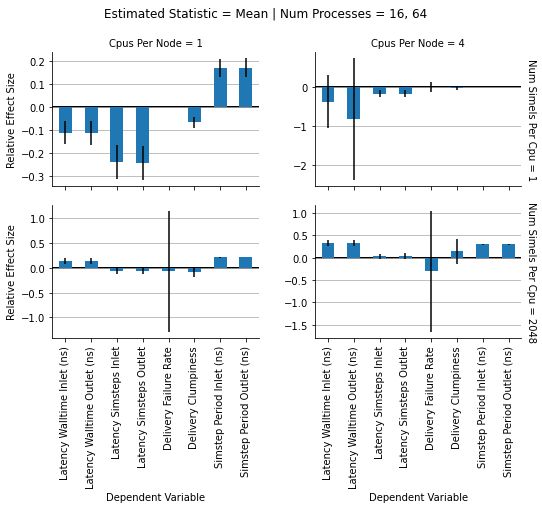

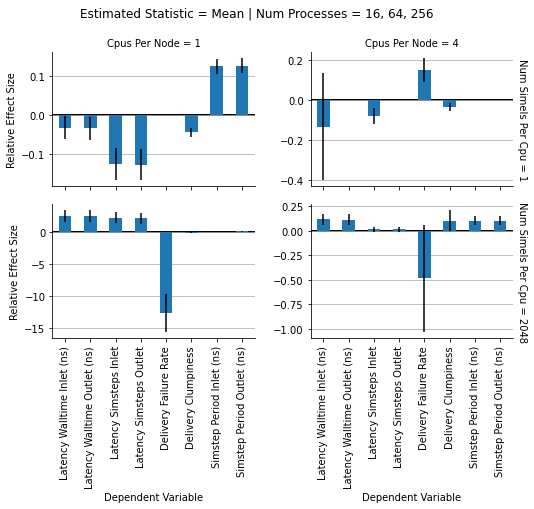

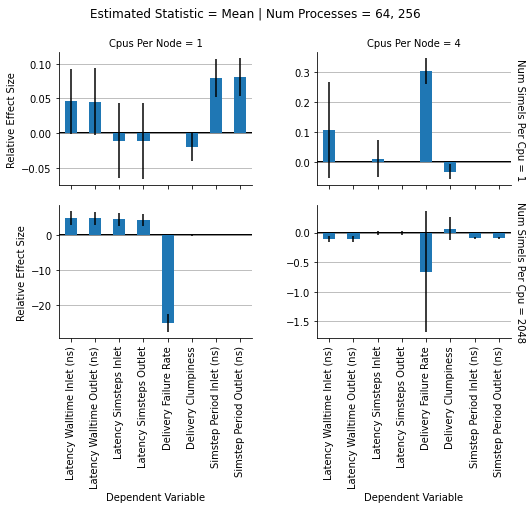

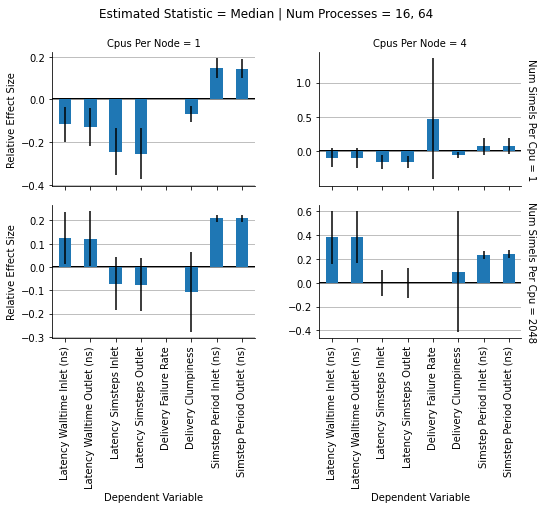

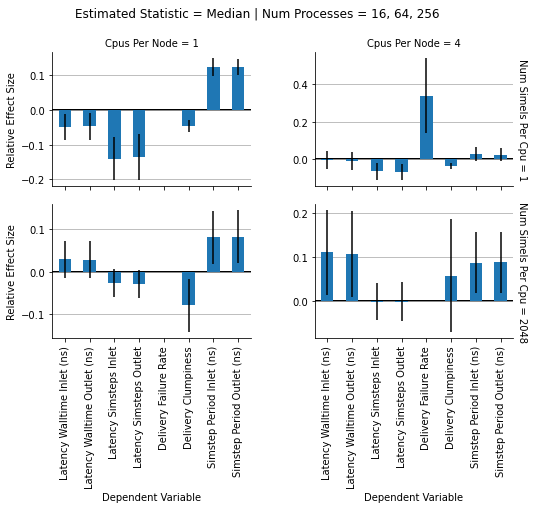

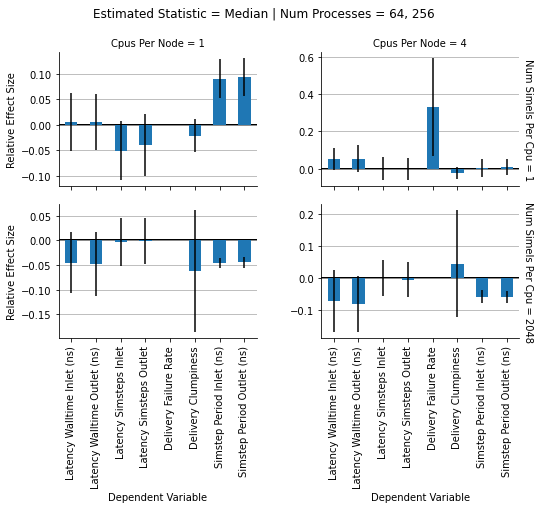

In [42]:
for (regression, num_processes), subset in weak_scaling_regression_results.groupby([
    'Regression Model',
    'Num Processes',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Relative Effect Size 95% CI Lower Bound',
            err_ub='Relative Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Dependent Variable',
        y='Relative Effect Size',
        estimated_statistic={
            'Quantile Regression' : 'Median',
            'Ordinary Least Squares Regression' : 'Mean',
        }[regression],
        num_processes=num_processes,
        size_inches=(8, 8),
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simste

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-stat

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-s

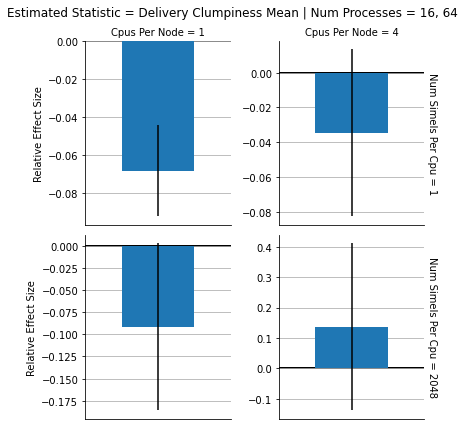

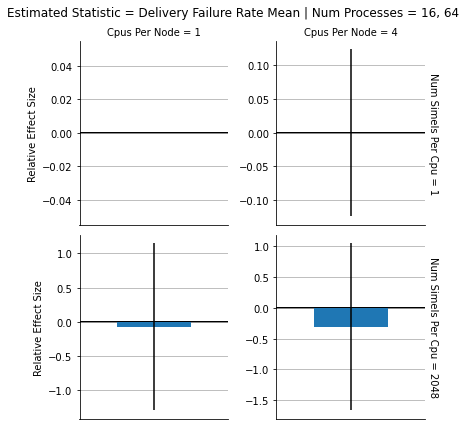

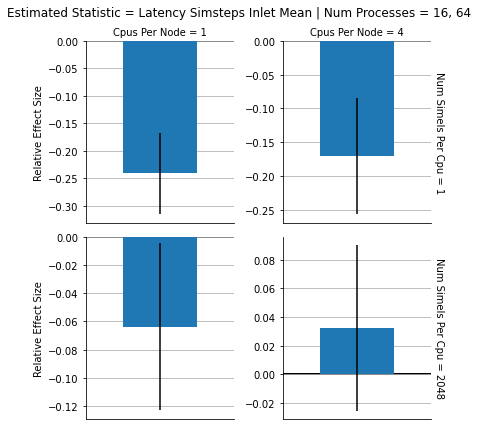

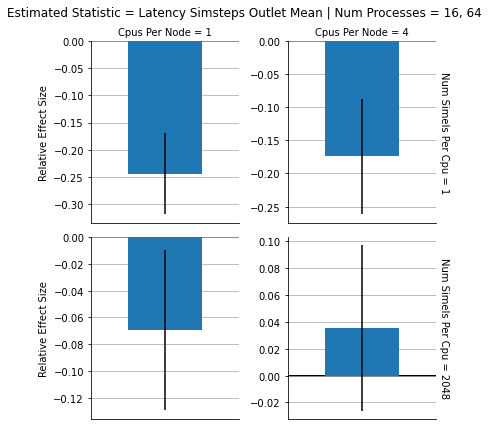

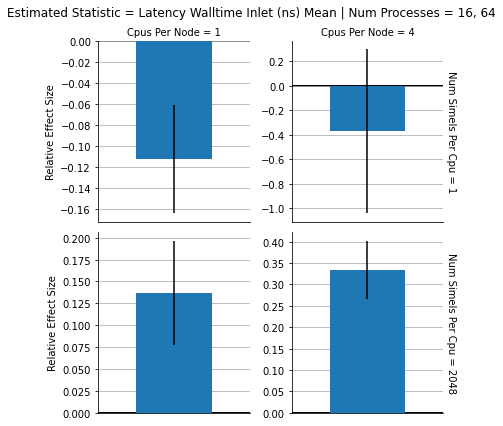

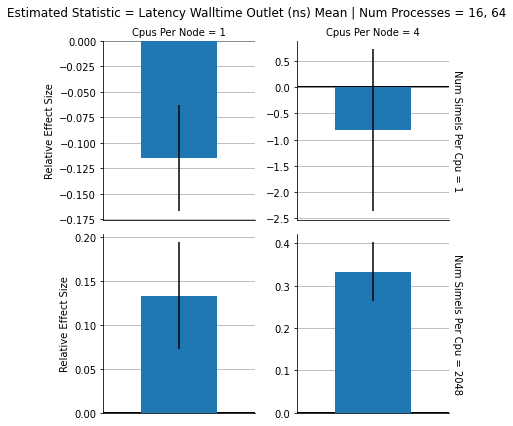

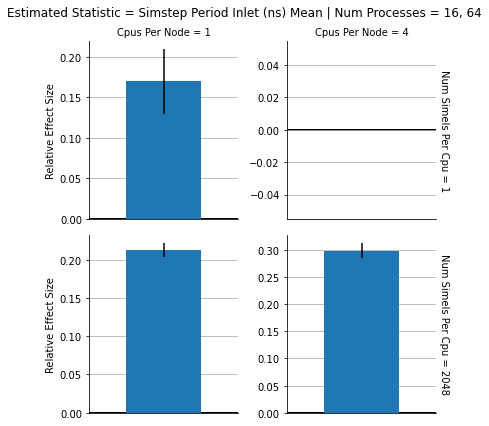

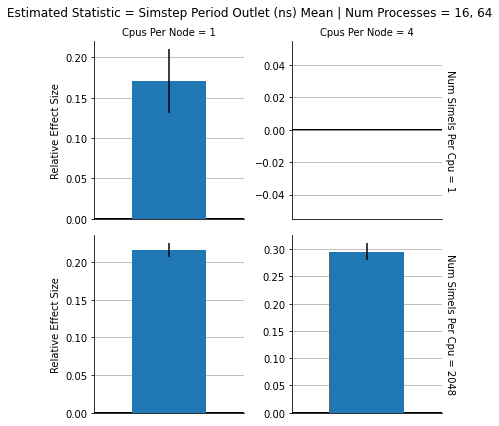

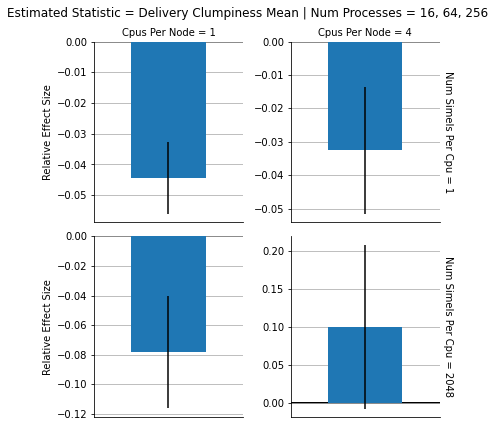

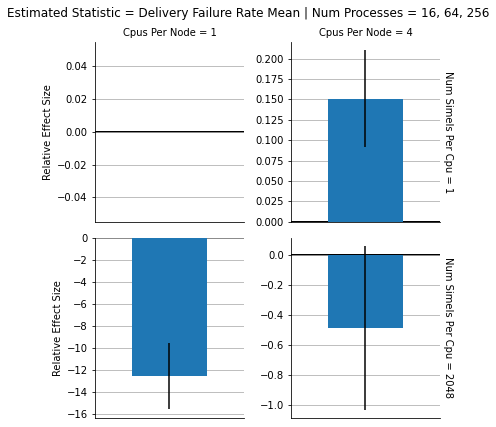

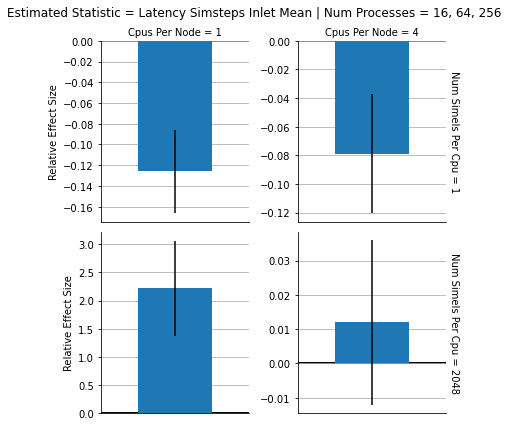

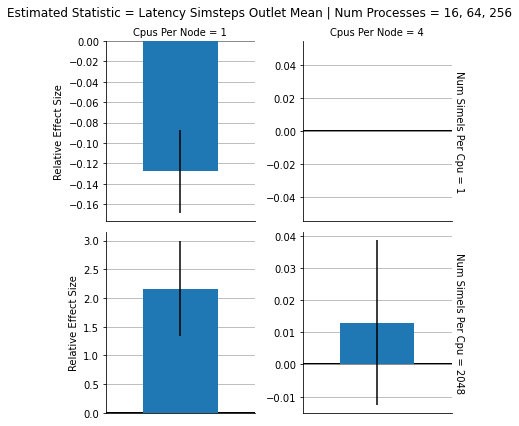

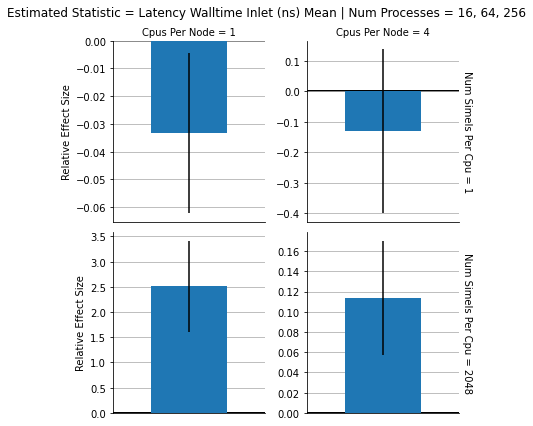

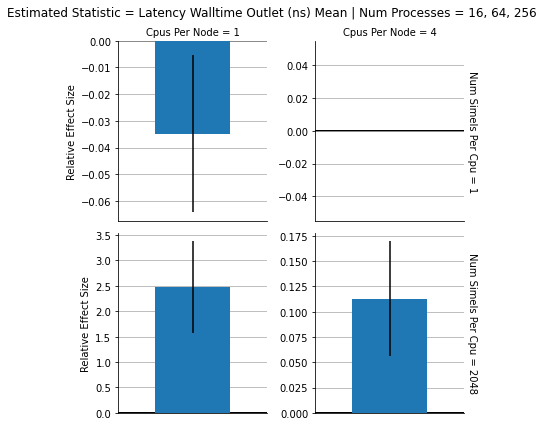

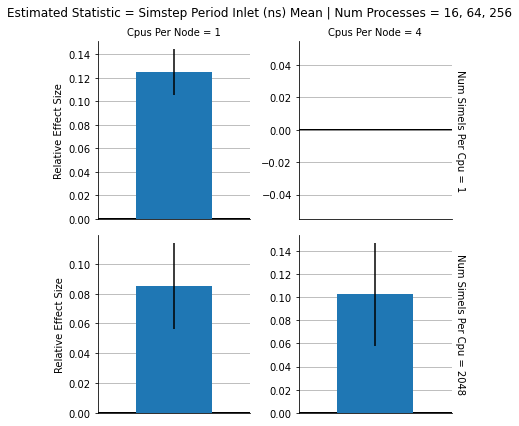

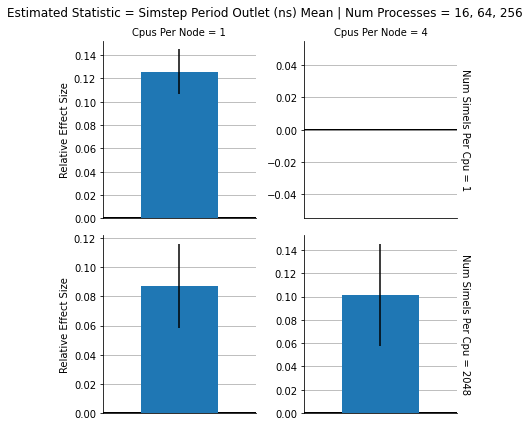

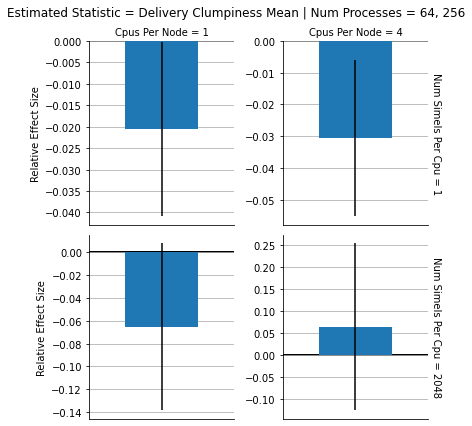

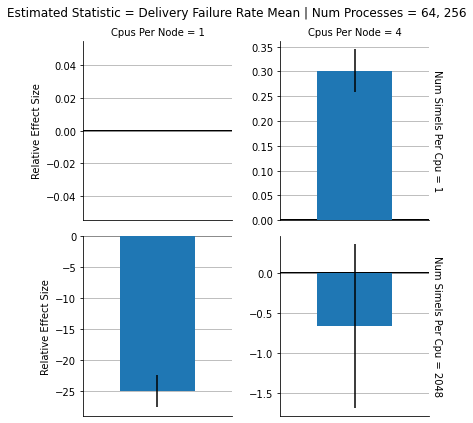

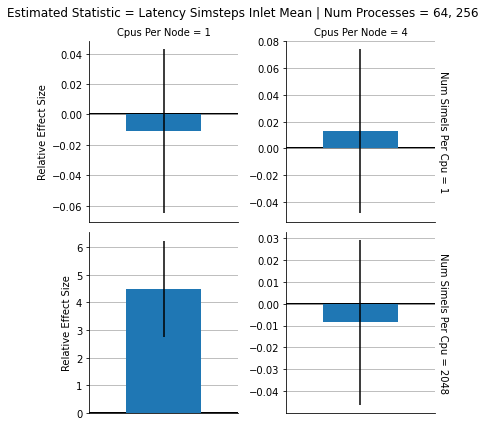

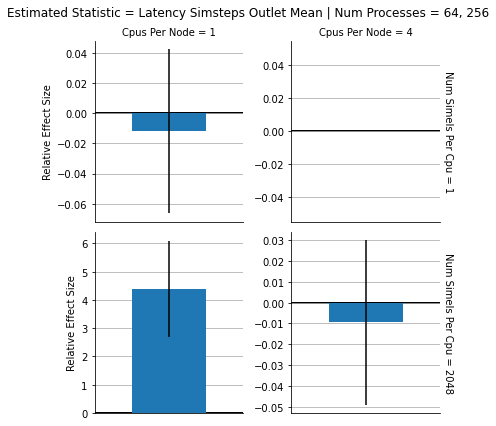

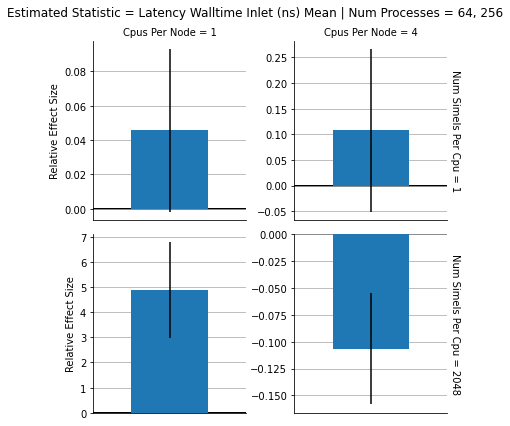

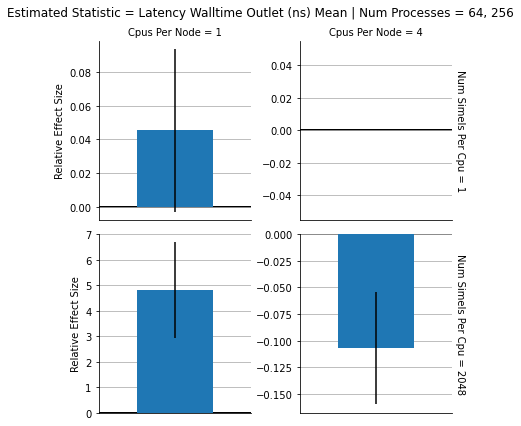

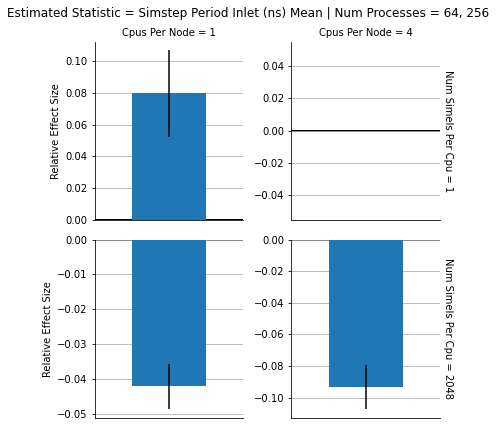

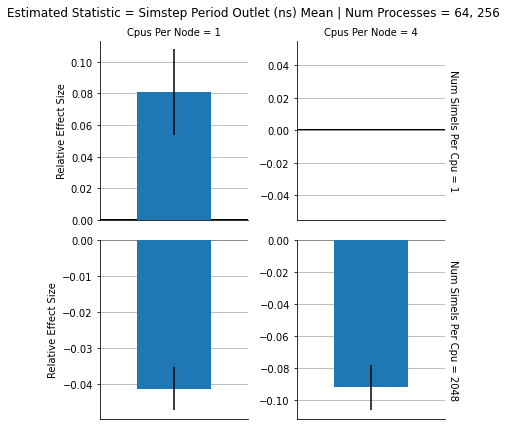

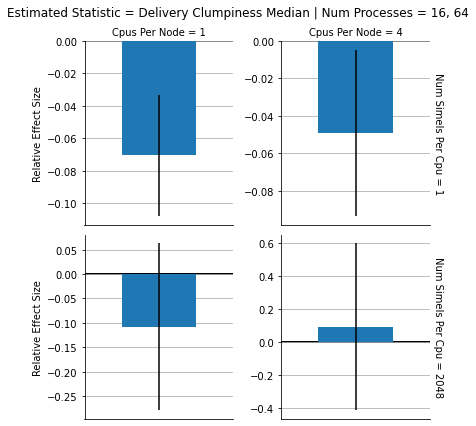

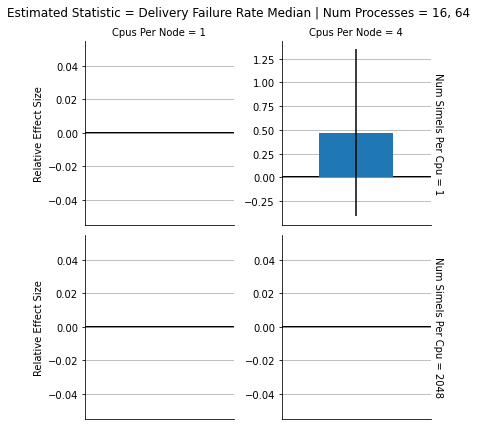

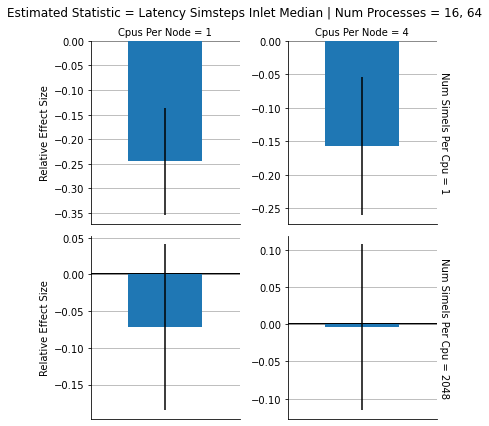

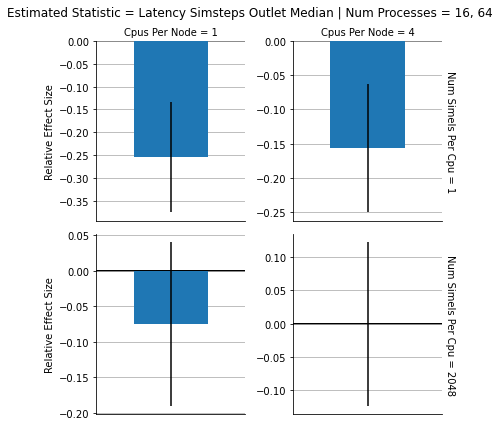

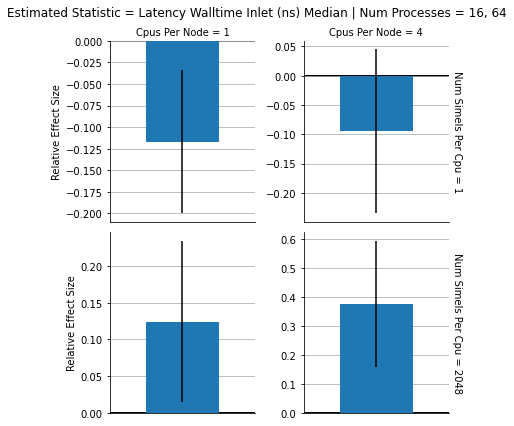

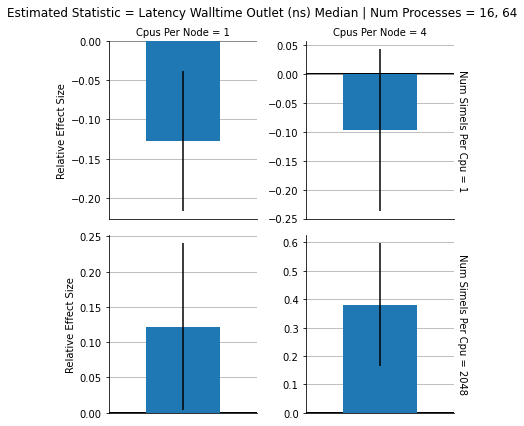

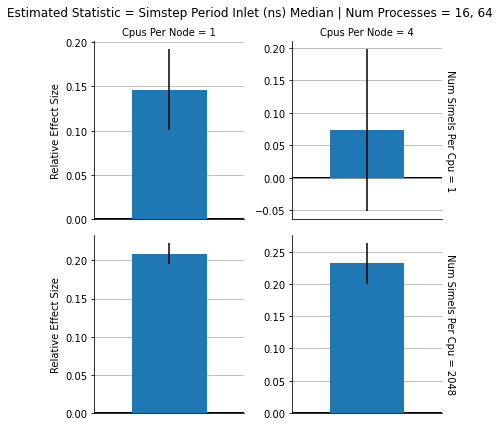

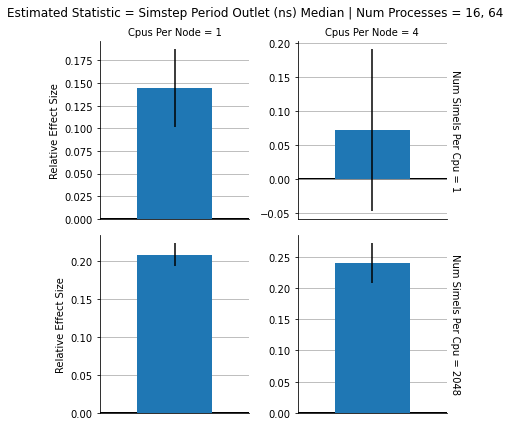

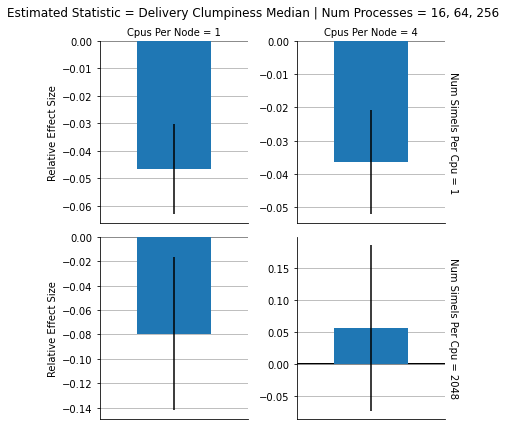

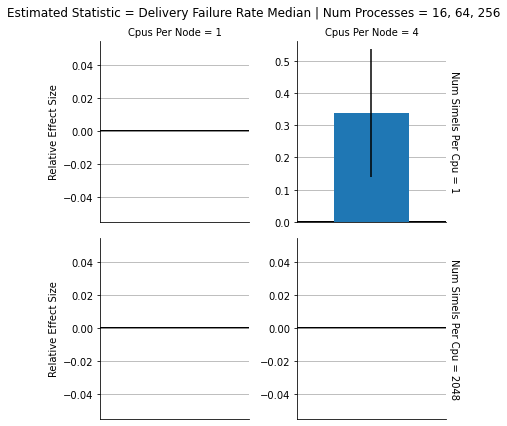

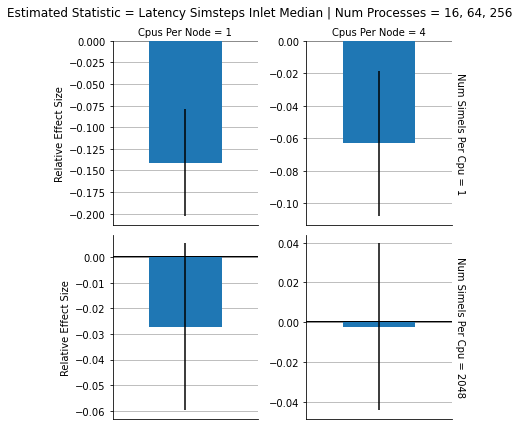

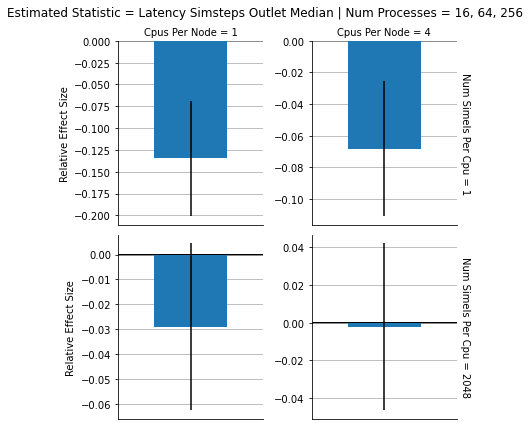

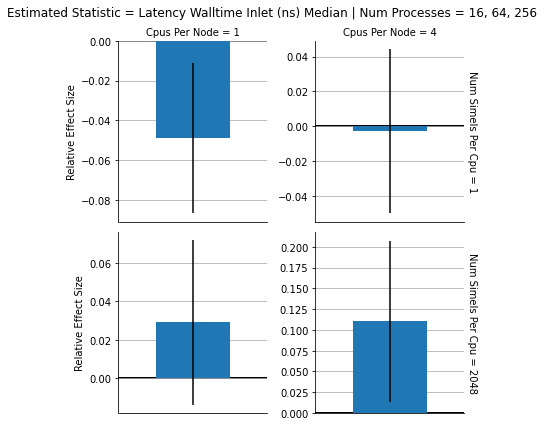

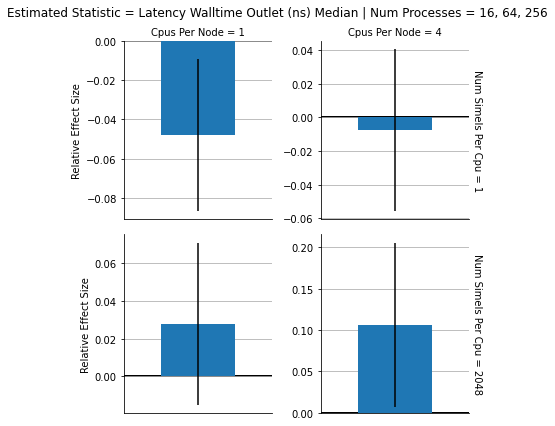

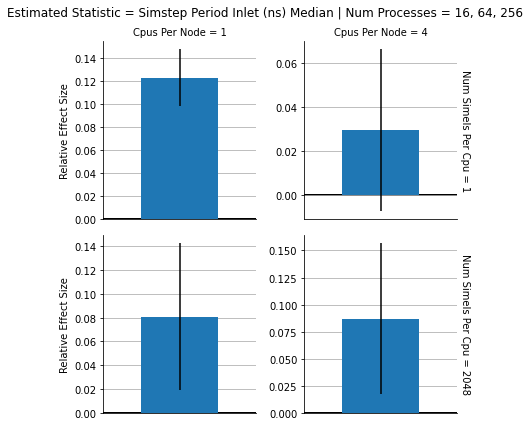

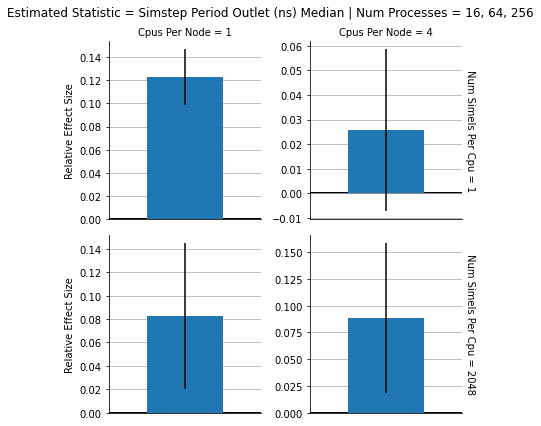

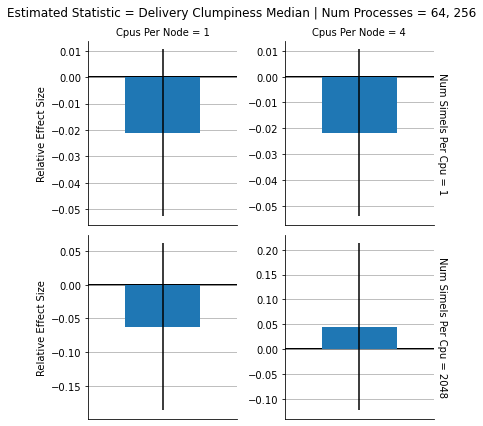

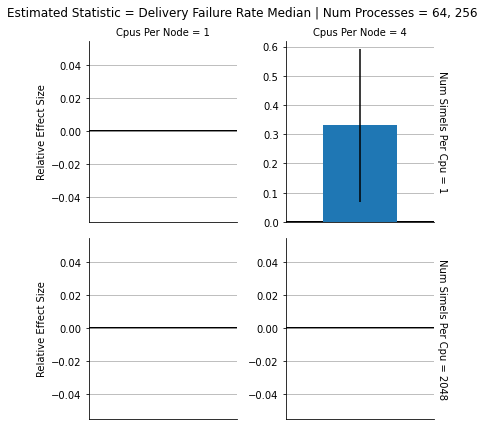

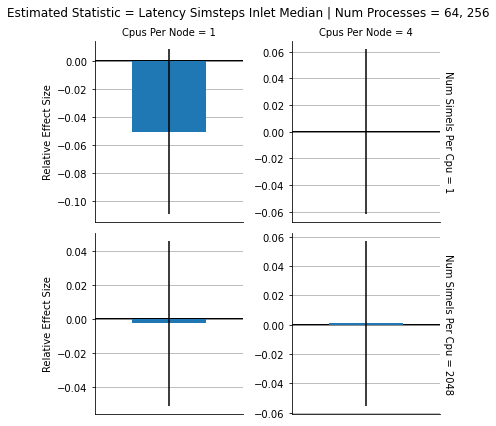

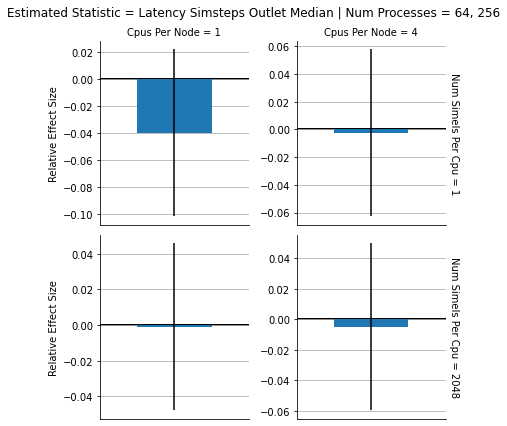

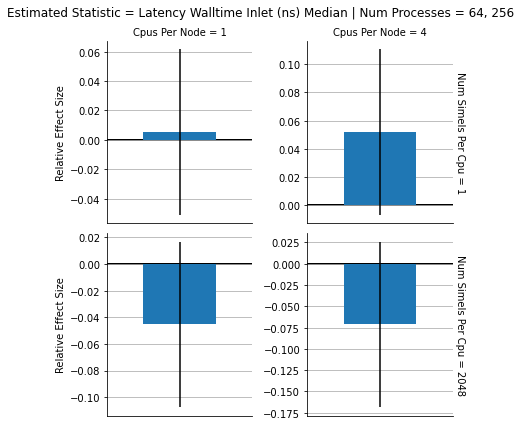

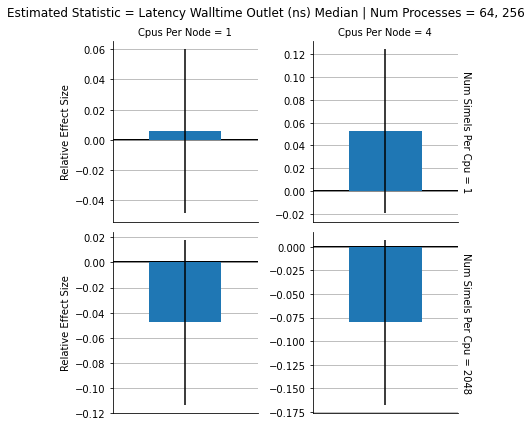

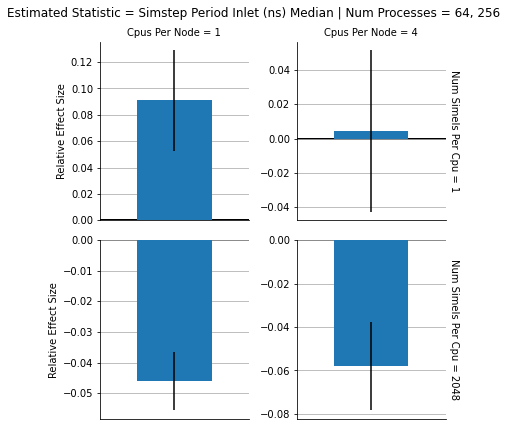

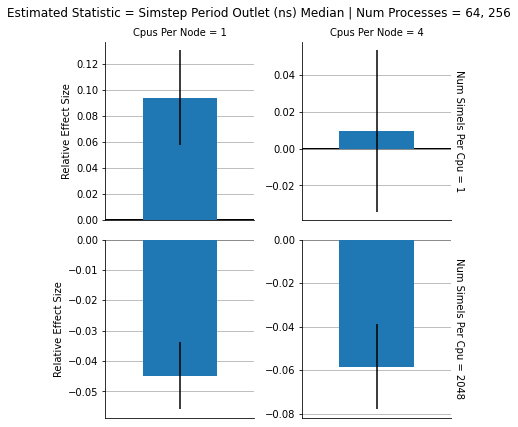

In [43]:
# relative estimates, alternate

for (regression, num_processes, dependent_variable), subset in weak_scaling_regression_results.groupby([
    'Regression Model',
    'Num Processes',
    'Dependent Variable',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Relative Effect Size 95% CI Lower Bound',
            err_ub='Relative Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        y='Relative Effect Size',
        estimated_statistic={
            'Quantile Regression' : f'{dependent_variable} Median',
            'Ordinary Least Squares Regression' : f'{dependent_variable} Mean',
        }[regression],
        num_processes=num_processes,
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-mean+num

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failu

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failur

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-walltime-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-inlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=simstep-period-outlet-ns-mean+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-clumpiness-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-median+num-processes=16-64+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simste

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-median+num-processes=16-64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-stat

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=delivery-failure-rate-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-inlet-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/col=cpus-per-node+estimated-statistic=latency-simsteps-outlet-median+num-processes=64-256+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/col=cpus-per-node+estimated-statistic=latency-s

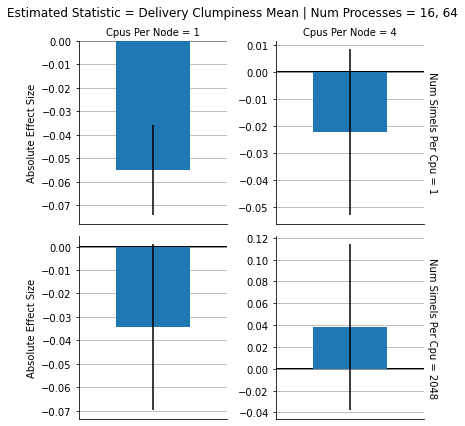

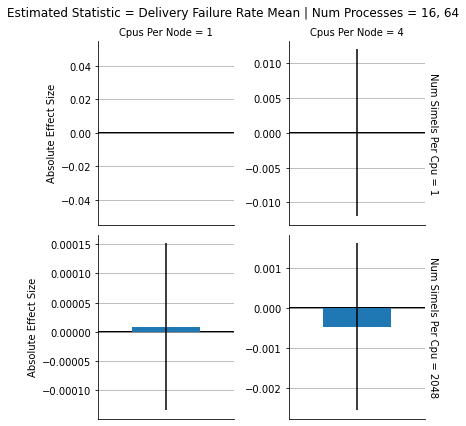

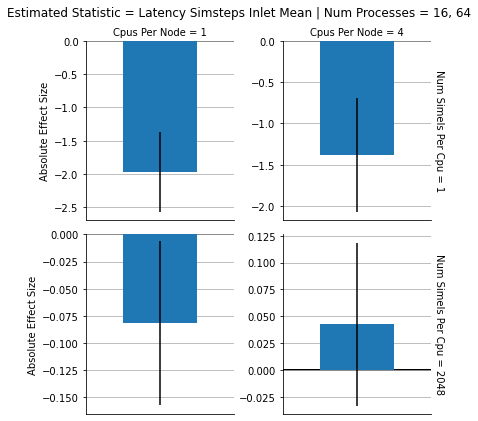

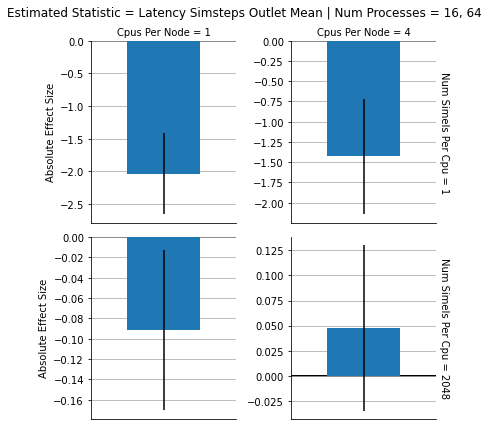

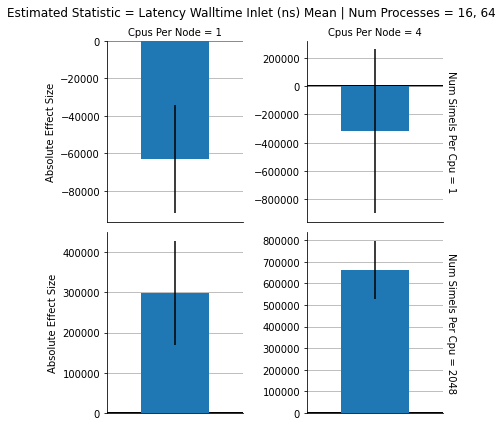

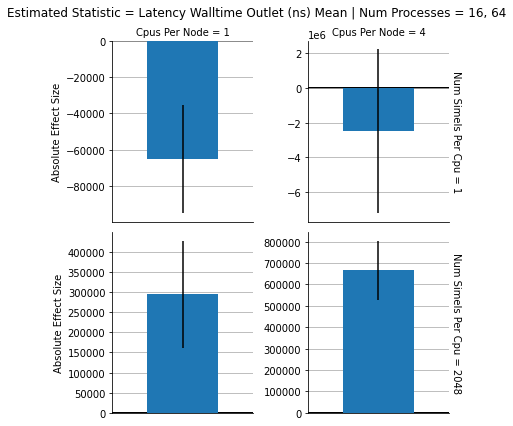

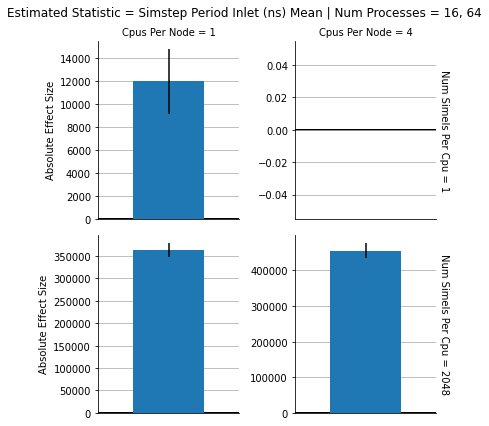

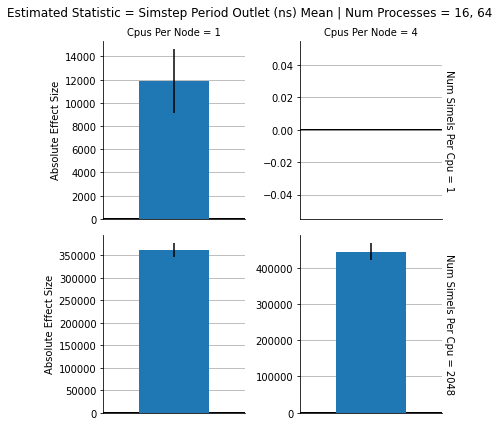

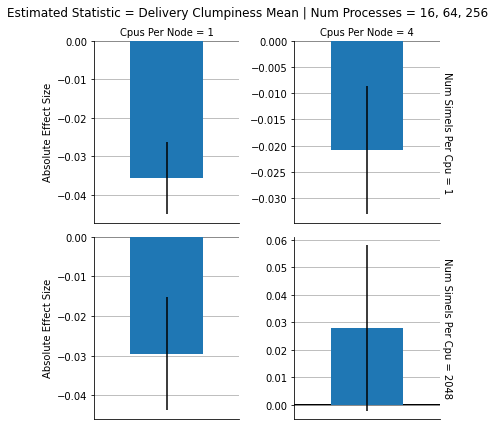

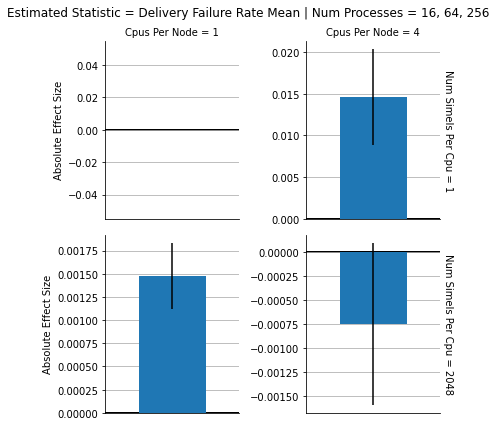

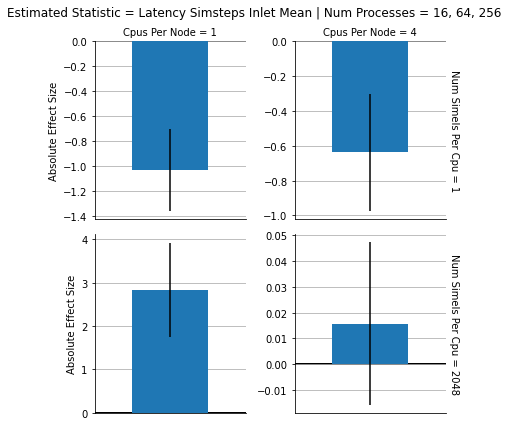

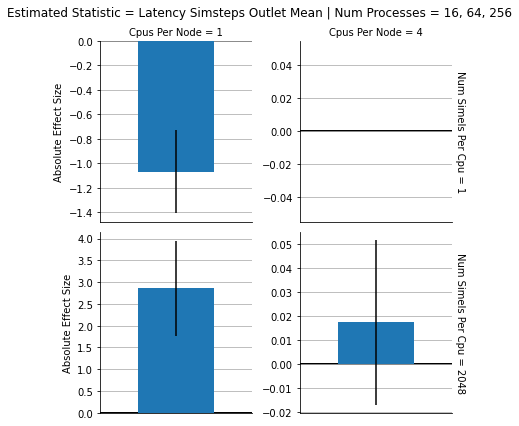

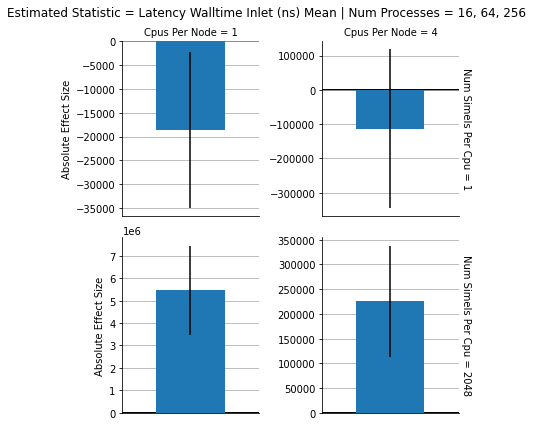

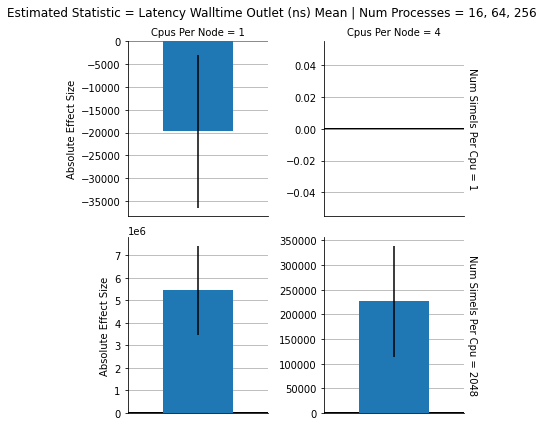

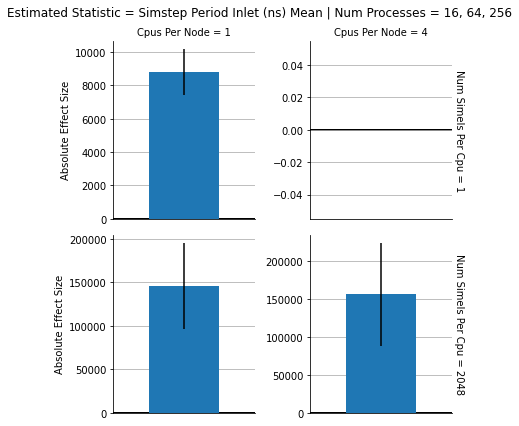

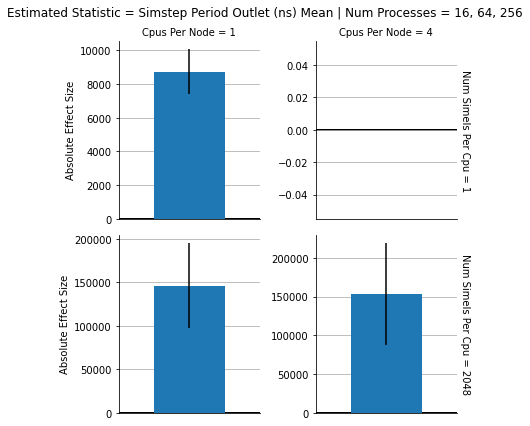

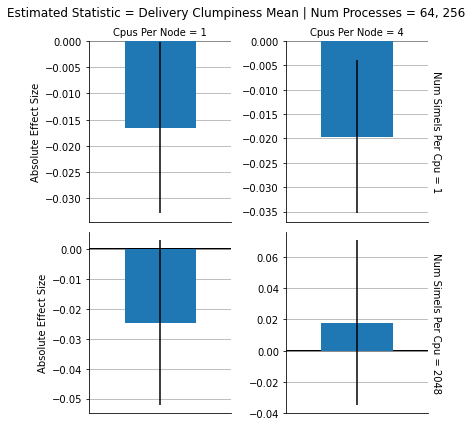

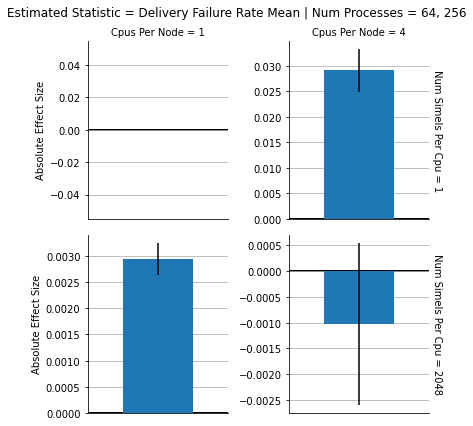

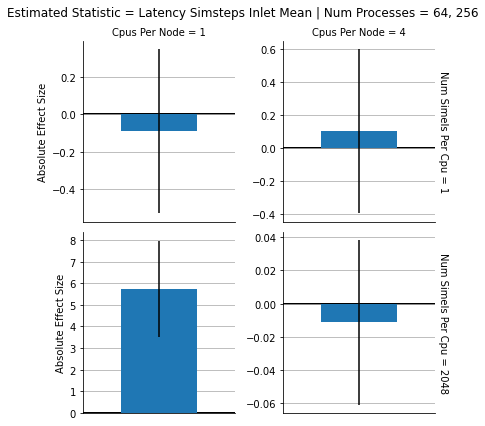

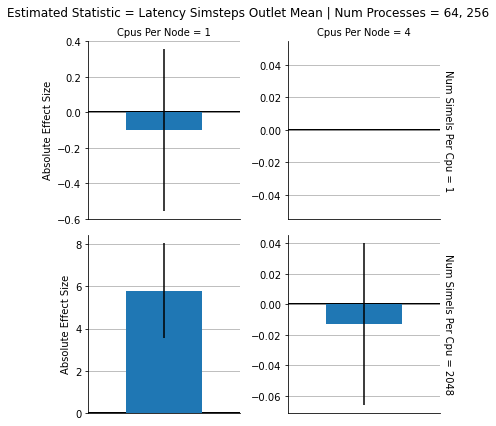

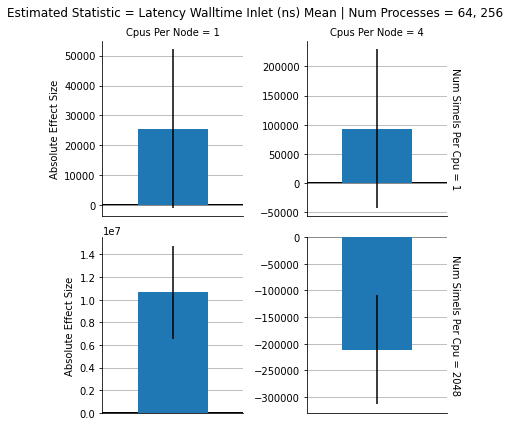

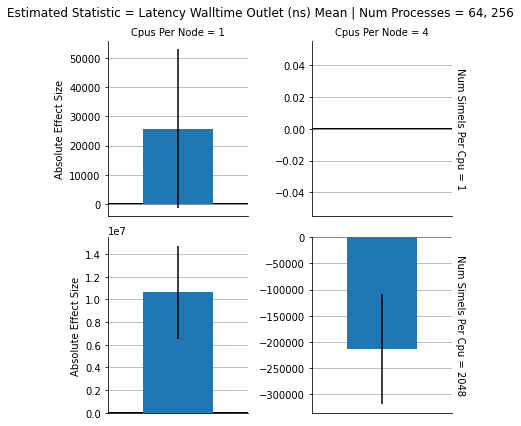

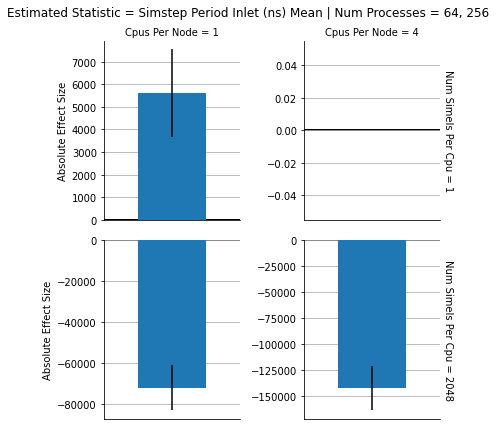

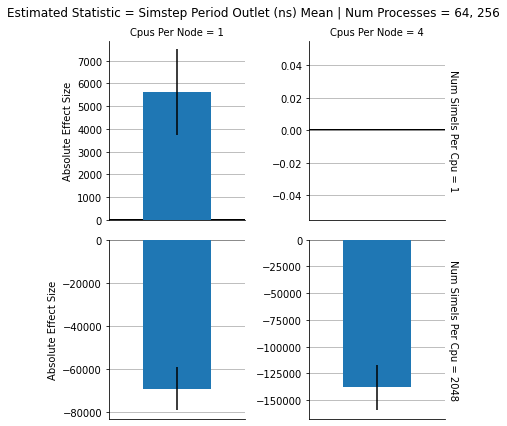

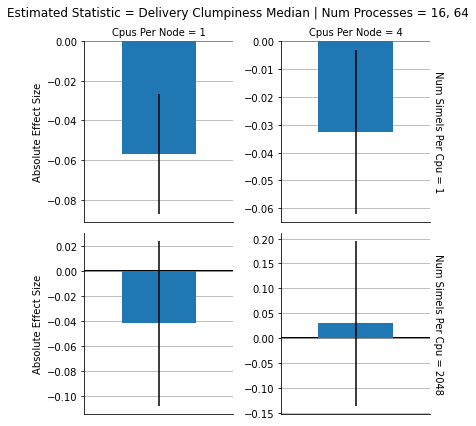

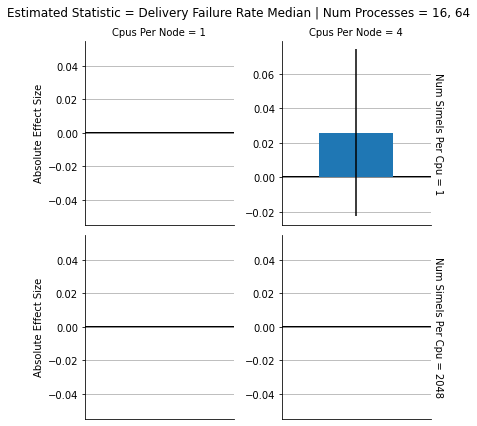

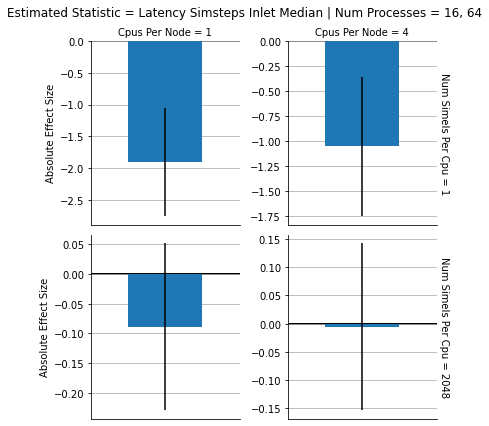

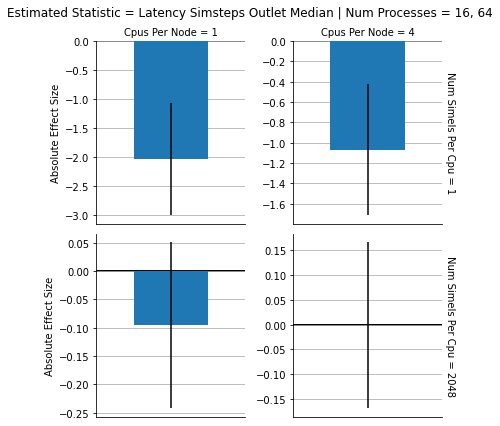

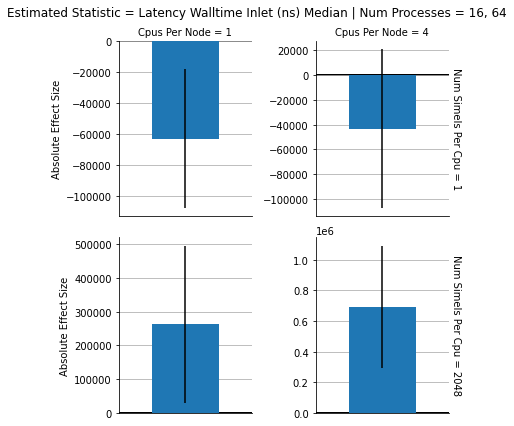

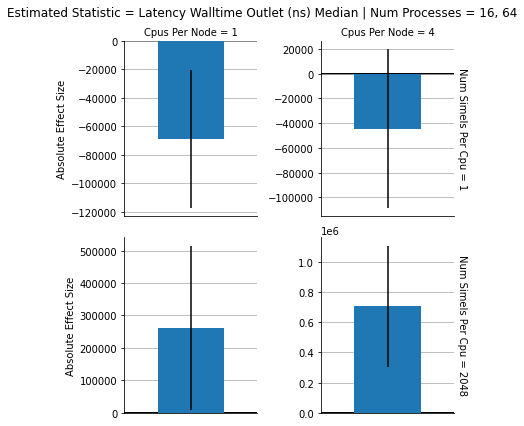

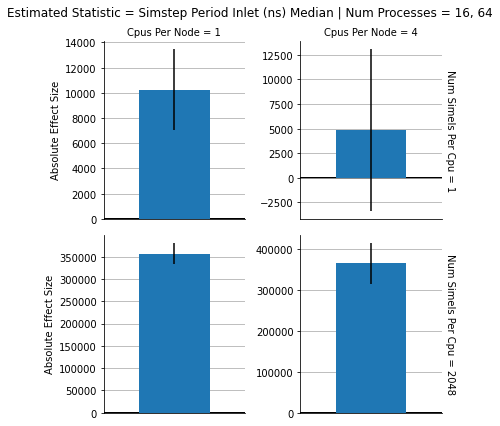

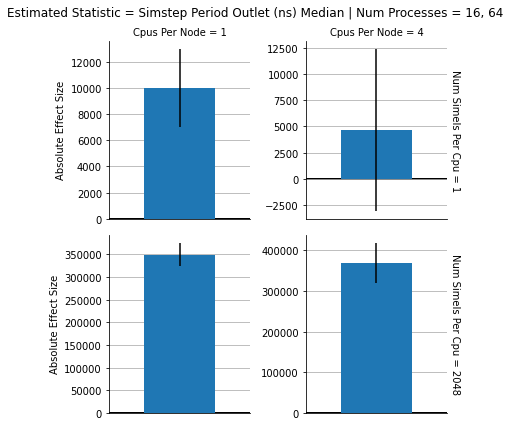

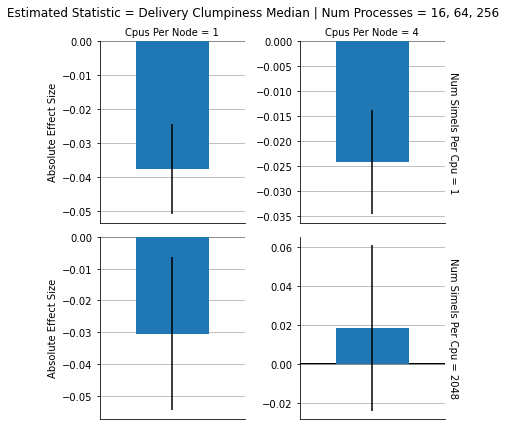

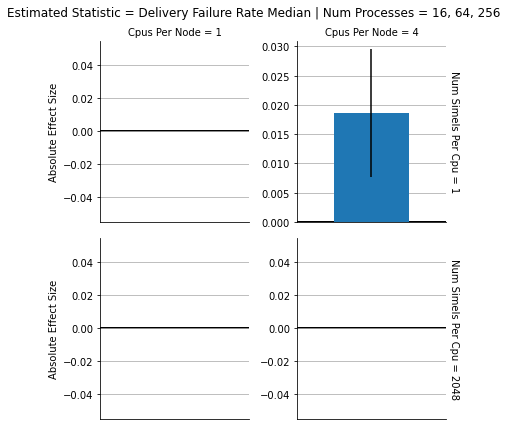

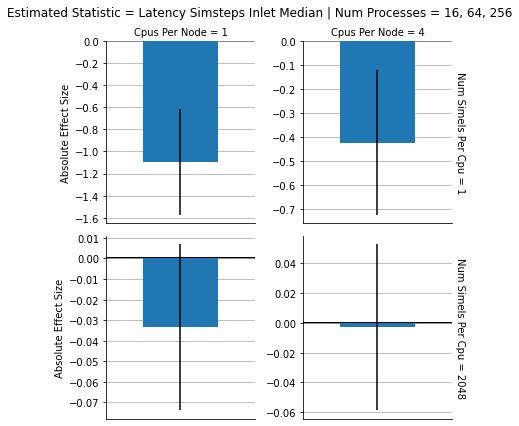

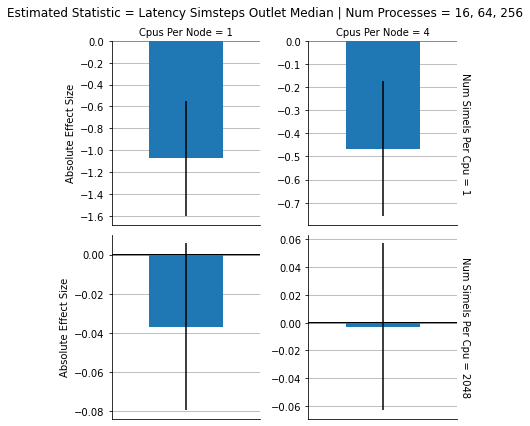

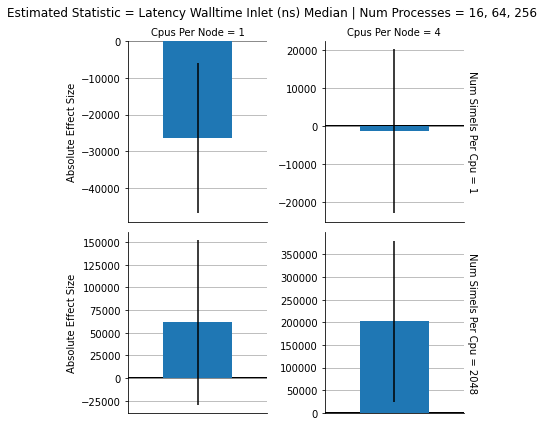

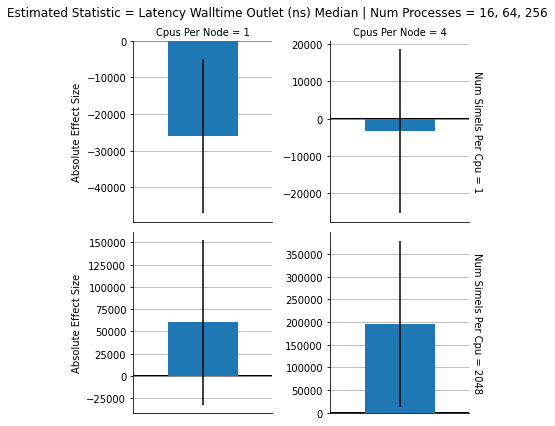

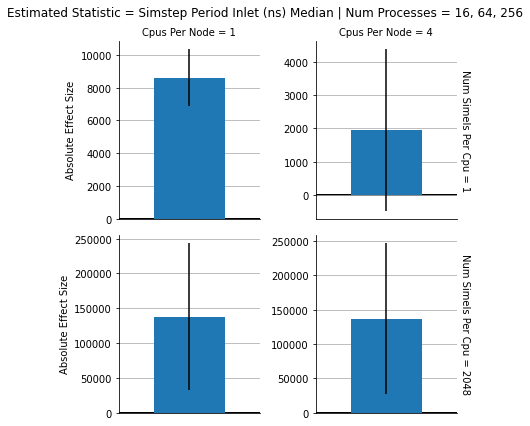

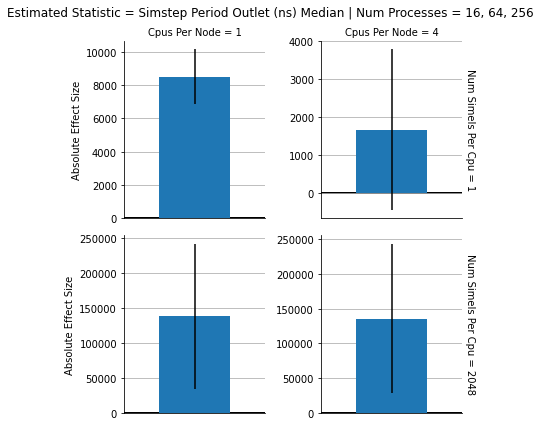

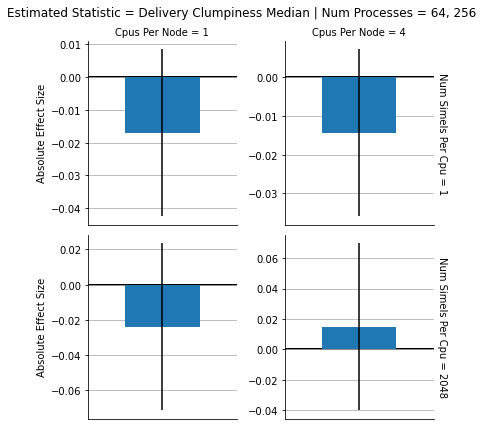

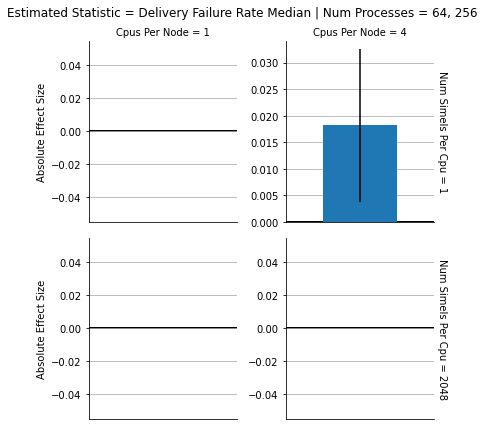

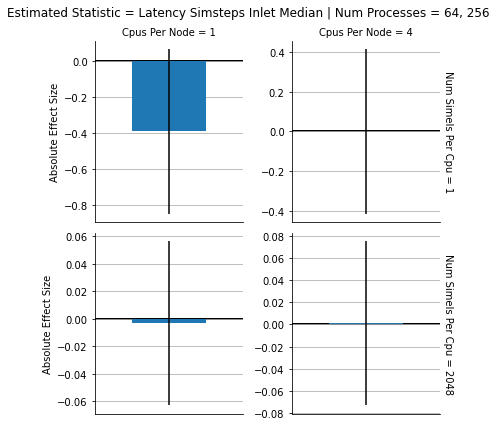

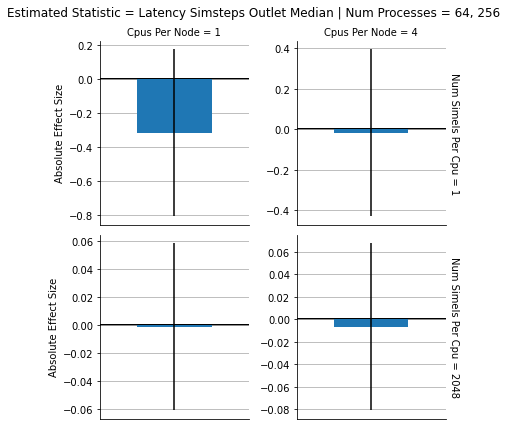

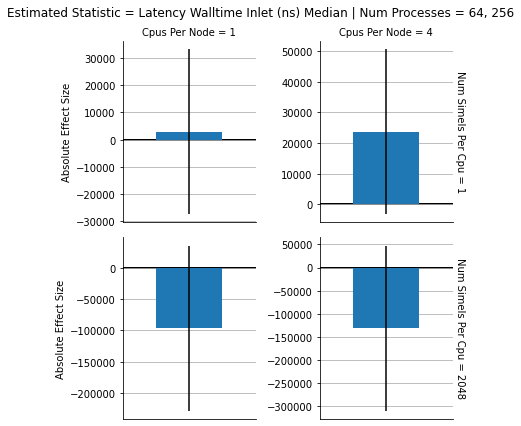

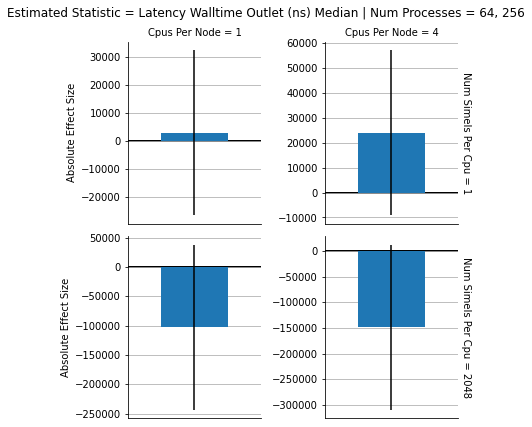

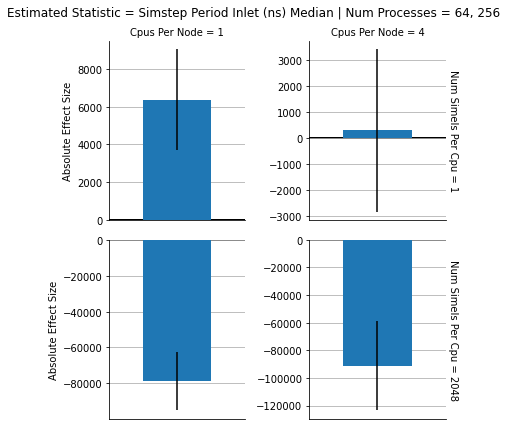

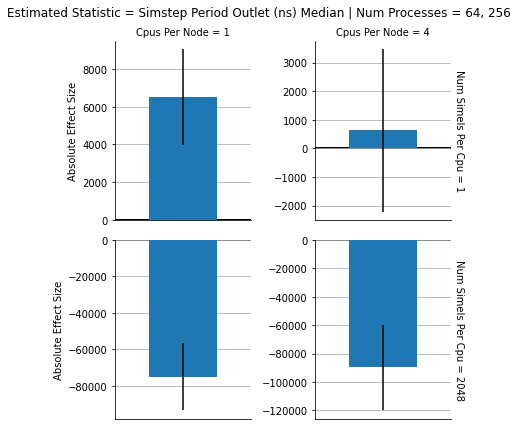

In [44]:
# absolute estimates

for (regression, num_processes, dependent_variable), subset in weak_scaling_regression_results.groupby([
    'Regression Model',
    'Num Processes',
    'Dependent Variable',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Absolute Effect Size 95% CI Lower Bound',
            err_ub='Absolute Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        y='Absolute Effect Size',
        estimated_statistic={
            'Quantile Regression' : f'{dependent_variable} Median',
            'Ordinary Least Squares Regression' : f'{dependent_variable} Mean',
        }[regression],
        num_processes=num_processes,
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

In [45]:
def quantile_regplot(fit_reg=True, color=None, *args, **kwargs):
    x, y, data = kwargs['x'], kwargs['y'], kwargs['data']
    sns.regplot(
        *args,
        **kwargs,
        fit_reg=False,
        color=color,
    )

    if fit_reg:
        model = smf.quantreg(
            f"Q('{y}') ~ Q('{x}')",
            data
        )
        res = model.fit(q=0.5)
        m = res.params[f"Q('{x}')"]
        b = res.params['Intercept']

        m_ci = res.conf_int().loc[f"Q('{x}')"].tolist()
        b_ci = res.conf_int().loc['Intercept'].tolist()

        center_x = np.mean([data[x].min(), data[x].max()])
        center_y = m * center_x + b

        xs = sorted(set(data[x]) | {center_x})
        ys = [
            m * x_ + b
            for x_ in xs
        ]
        y1 = [ min(
                m_ * ( x_ - center_x ) + center_y
                for m_ in m_ci
        ) for x_ in xs ]
        y2 = [ max(
                m_ * ( x_ - center_x ) + center_y
                for m_ in m_ci
        ) for x_ in xs ]

        plt.gca().plot(
            xs,
            ys,
            color=color,
        )
        plt.gca().fill_between(
            xs,
            y1,
            y2,
            alpha=0.2,
            color=color,
        )

In [46]:
def unsplit_regression(*args, regplot, **kwargs):
    del kwargs['color']
    regplot(
        *args,
        **kwargs,
        color='black',
        fit_reg=False,
    )
    regplot(
        *args,
        **kwargs,
        color='purple',
        scatter=False,
    )

    # adapted from https://www.scivision.dev/matplotlib-force-integer-labeling-of-axis/
    plt.gca().xaxis.set_major_locator(
        matplotlib.ticker.MaxNLocator(
            integer=True,
        ),
    )

def facet_unsplit_regression(*, data, col, row, x, y, regression, **kwargs):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey=False,
    )
    g.map_dataframe(
        unsplit_regression,
        regplot={
            'Ordinary Least Squares Regression' : sns.regplot,
            'Quantile Regression' : quantile_regplot,
        }[regression],
        x=x,
        y=y,
        **kwargs,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

    # adapted from https://stackoverflow.com/a/29814281
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().suptitle(regression)

In [47]:
def split_regression(*args, regplot, **kwargs):
    del kwargs['color']
    regplot(
        *args,
        **kwargs,
        color='black',
        fit_reg=False,
    )
    data = kwargs.pop('data')
    regplot(
        *args,
        **kwargs,
        color='red',
        data=data[ data['Log Num Processes'] >= 3 ],
        scatter=False,
    )
    regplot(
        *args,
        **kwargs,
        color='blue',
        data=data[ data['Log Num Processes'] <= 3 ],
        scatter=False,
    )

    # adapted from https://www.scivision.dev/matplotlib-force-integer-labeling-of-axis/
    plt.gca().xaxis.set_major_locator(
        matplotlib.ticker.MaxNLocator(
            integer=True,
        ),
    )

def facet_split_regression(*, data, col, row, x, y, regression, **kwargs):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey=False,
    )
    g.map_dataframe(
        split_regression,
        x=x,
        y=y,
        regplot={
            'Ordinary Least Squares Regression' : sns.regplot,
            'Quantile Regression' : quantile_regplot,
        }[regression],
        **kwargs,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

    # adapted from https://stackoverflow.com/a/29814281
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().suptitle(regression)

In [48]:
def split_unsplit_regression(*args, regplot, **kwargs):
    del kwargs['color']
    regplot(
        *args,
        **kwargs,
        color='black',
        fit_reg=False,
    )
    regplot(
        *args,
        **kwargs,
        color='purple',
        scatter=False,
    )
    data = kwargs.pop('data')
    regplot(
        *args,
        **kwargs,
        color='red',
        data=data[ data['Log Num Processes'] >= 3 ],
        scatter=False,
    )
    regplot(
        *args,
        **kwargs,
        color='blue',
        data=data[ data['Log Num Processes'] <= 3 ],
        scatter=False,
    )

    # adapted from https://www.scivision.dev/matplotlib-force-integer-labeling-of-axis/
    plt.gca().xaxis.set_major_locator(
        matplotlib.ticker.MaxNLocator(
            integer=True,
        ),
    )

def facet_split_unsplit_regression(*, data, col, row, x, y, regression, **kwargs):
    g = sns.FacetGrid(
        data,
        col=col,
        row=row,
        margin_titles=True,
        sharey=False,
    )
    g.map_dataframe(
        split_unsplit_regression,
        x=x,
        y=y,
        regplot={
            'Ordinary Least Squares Regression' : sns.regplot,
            'Quantile Regression' : quantile_regplot,
        }[regression],
        **kwargs,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

    # adapted from https://stackoverflow.com/a/29814281
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().suptitle(regression)

## Latency Walltime Inlet (ns)

In [49]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Walltime Inlet (ns)'])
][[
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Latency Walltime Inlet (ns)  Latency Walltime Outlet (ns)  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                            NaN                           NaN         3                           181.5  lac-050          0                   1              4            256
868                            NaN                           NaN         4                           241.5  lac-050          0                   1              4            256
869                            NaN                           NaN         5                           301.5  lac-050          0                   1              4            256
13477                          NaN                           inf         1                            60.5  lac-188          6                   1              4            256
13478                          NaN                           inf         2                           120.5  lac-188          6                   1              4            256
13479                          NaN                           NaN         3                           180.5  lac-188          6                   1              4            256
13480                          NaN                           NaN         4                           240.5  lac-188          6                   1              4            256
13481                          NaN                           NaN         5                           300.5  lac-188          6                   1              4            256
52394                          NaN                           NaN         2                           120.5  lac-046          9                   1              4             16
52395                          NaN                           NaN         3                           180.5  lac-046          9                   1              4             16
52396                          NaN                           NaN         4                           240.5  lac-046          9                   1              4             16
52397                          NaN                  2.021284e+09         5                           300.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.png
teeplots/col=cpus-per-node+m

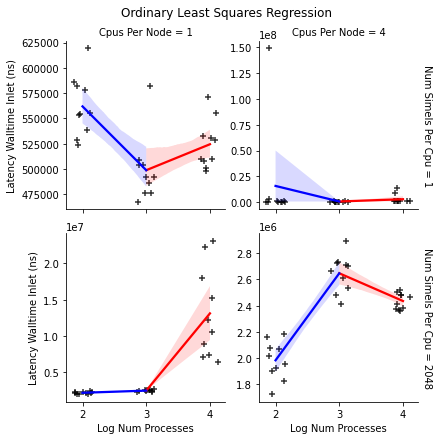

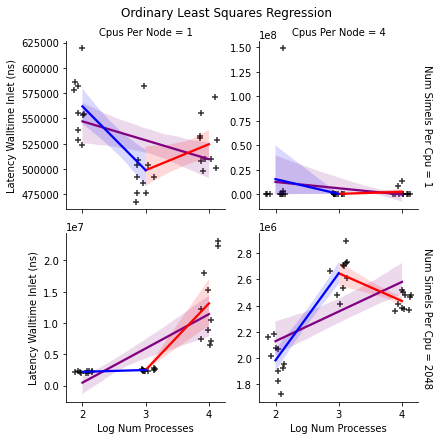

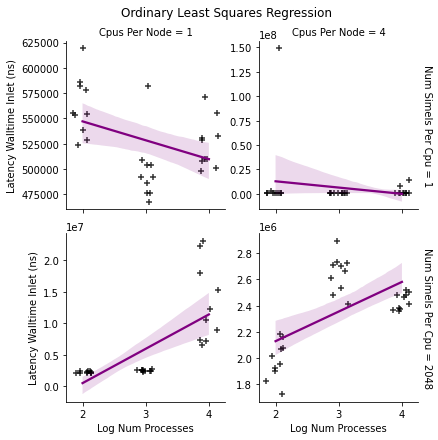

In [50]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Walltime Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Walltime Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-si

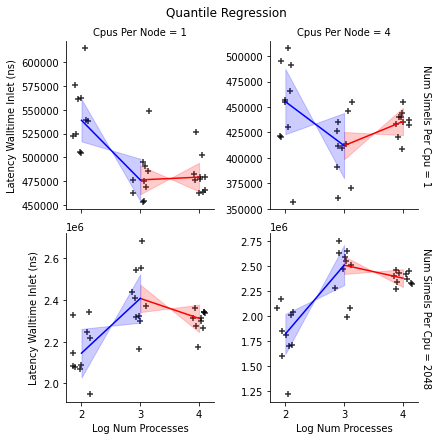

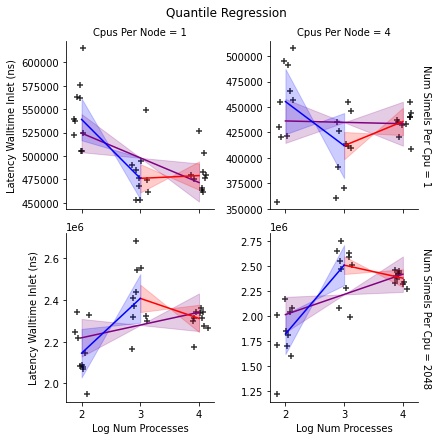

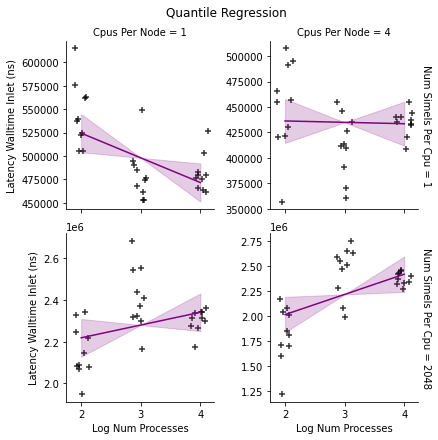

In [51]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Walltime Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Latency Walltime Outlet (ns)

In [52]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Walltime Outlet (ns)'])
][[
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Latency Walltime Inlet (ns)  Latency Walltime Outlet (ns)  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                            NaN                           NaN         3                           181.5  lac-050          0                   1              4            256
868                            NaN                           NaN         4                           241.5  lac-050          0                   1              4            256
869                            NaN                           NaN         5                           301.5  lac-050          0                   1              4            256
13477                          NaN                           inf         1                            60.5  lac-188          6                   1              4            256
13478                          NaN                           inf         2                           120.5  lac-188          6                   1              4            256
13479                          NaN                           NaN         3                           180.5  lac-188          6                   1              4            256
13480                          NaN                           NaN         4                           240.5  lac-188          6                   1              4            256
13481                          NaN                           NaN         5                           300.5  lac-188          6                   1              4            256
52394                          NaN                           NaN         2                           120.5  lac-046          9                   1              4             16
52395                          NaN                           NaN         3                           180.5  lac-046          9                   1              4             16
52396                          NaN                           NaN         4                           240.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.png
teeplots/col=cpus-per-no

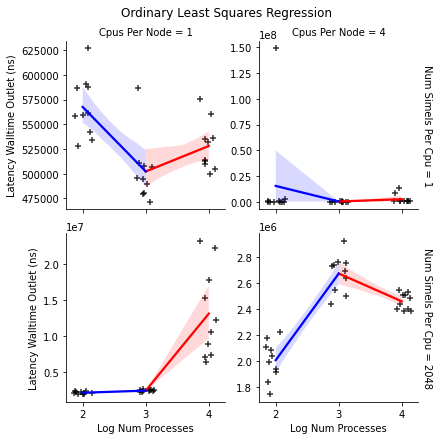

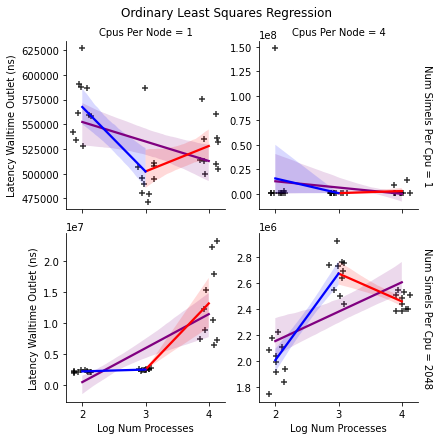

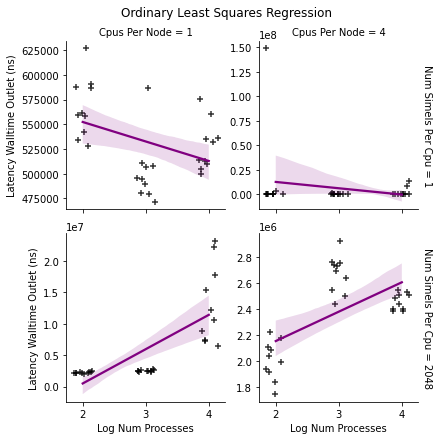

In [53]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Walltime Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)


data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Walltime Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-walltime-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=nu

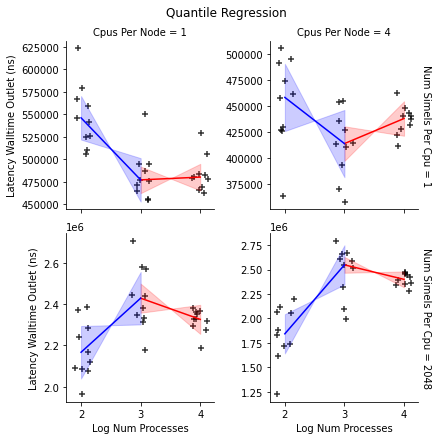

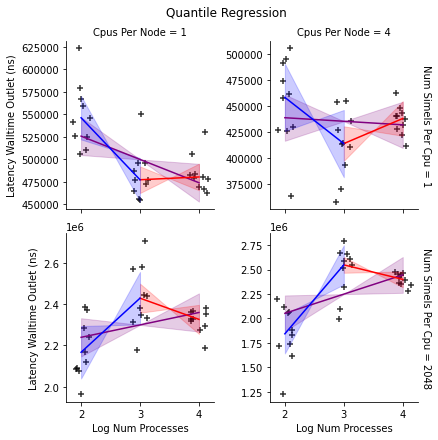

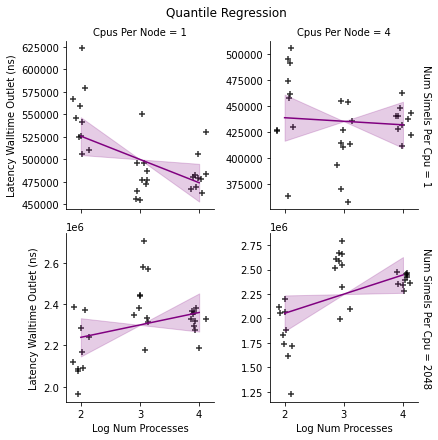

In [54]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Walltime Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Latency Simsteps Inlet

In [55]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Simsteps Inlet'])
][[
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Latency Simsteps Inlet  Latency Simsteps Outlet  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                       NaN                      NaN         3                           181.5  lac-050          0                   1              4            256
868                       NaN                      NaN         4                           241.5  lac-050          0                   1              4            256
869                       NaN                      NaN         5                           301.5  lac-050          0                   1              4            256
13477                     NaN                      inf         1                            60.5  lac-188          6                   1              4            256
13478                     NaN                      inf         2                           120.5  lac-188          6                   1              4            256
13479                     NaN                      NaN         3                           180.5  lac-188          6                   1              4            256
13480                     NaN                      NaN         4                           240.5  lac-188          6                   1              4            256
13481                     NaN                      NaN         5                           300.5  lac-188          6                   1              4            256
52394                     NaN                      NaN         2                           120.5  lac-046          9                   1              4             16
52395                     NaN                      NaN         3                           180.5  lac-046          9                   1              4             16
52396                     NaN                      NaN         4                           240.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.png
teeplots/col=cpus-per-node+marker=+regre

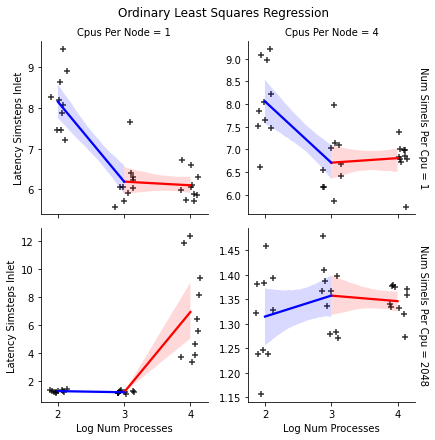

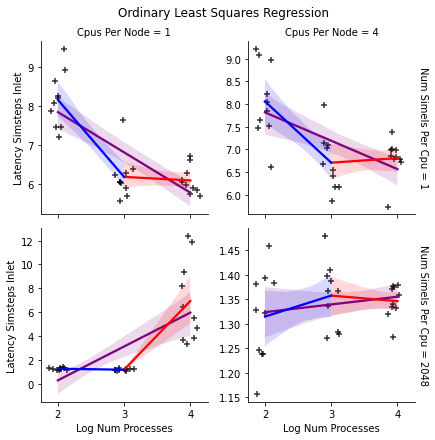

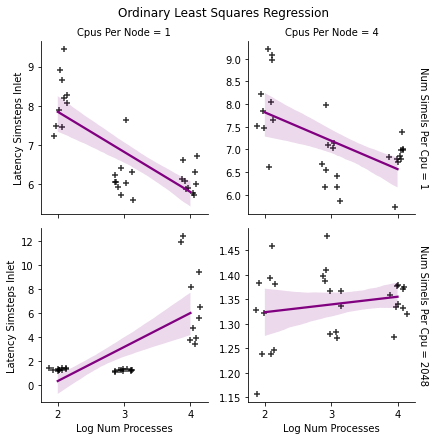

In [56]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Simsteps Inlet'] = (
    df_snapshot_diffs_copy['Num Puts Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Simsteps Inlet',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-inlet+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu

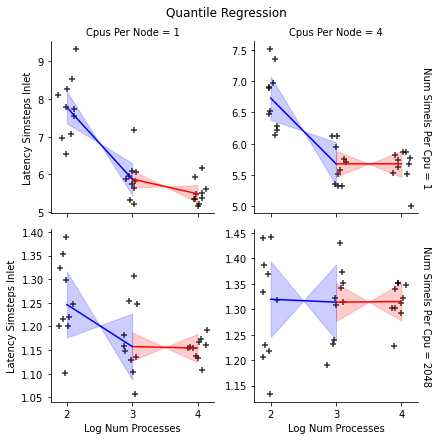

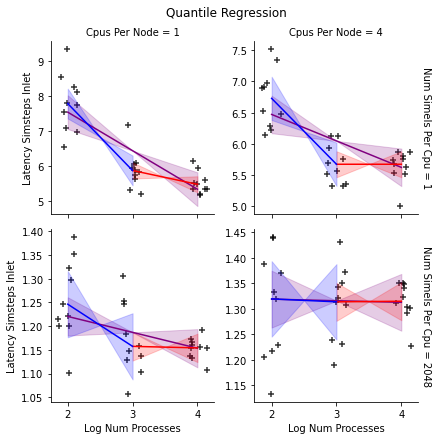

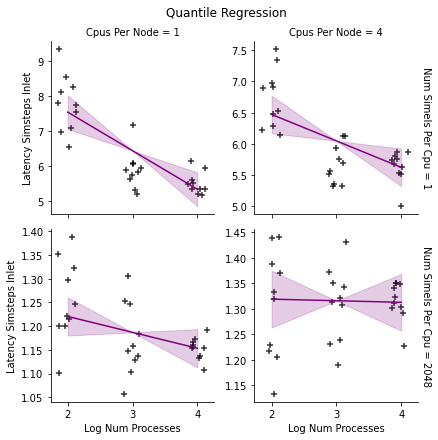

In [57]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Simsteps Inlet',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Latency Simsteps Outlet

In [58]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Simsteps Outlet'])
][[
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Latency Simsteps Inlet  Latency Simsteps Outlet  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                       NaN                      NaN         3                           181.5  lac-050          0                   1              4            256
868                       NaN                      NaN         4                           241.5  lac-050          0                   1              4            256
869                       NaN                      NaN         5                           301.5  lac-050          0                   1              4            256
13477                     NaN                      inf         1                            60.5  lac-188          6                   1              4            256
13478                     NaN                      inf         2                           120.5  lac-188          6                   1              4            256
13479                     NaN                      NaN         3                           180.5  lac-188          6                   1              4            256
13480                     NaN                      NaN         4                           240.5  lac-188          6                   1              4            256
13481                     NaN                      NaN         5                           300.5  lac-188          6                   1              4            256
52394                     NaN                      NaN         2                           120.5  lac-046          9                   1              4             16
52395                     NaN                      NaN         3                           180.5  lac-046          9                   1              4             16
52396                     NaN                      NaN         4                           240.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.png
teeplots/col=cpus-per-node+marker=+r

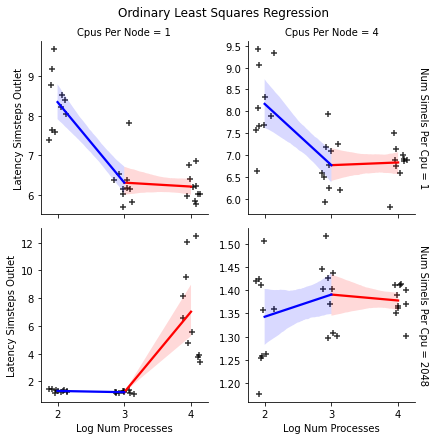

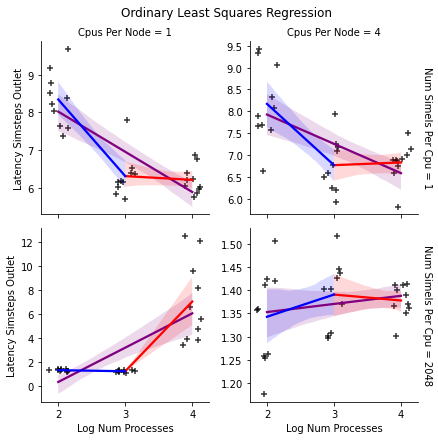

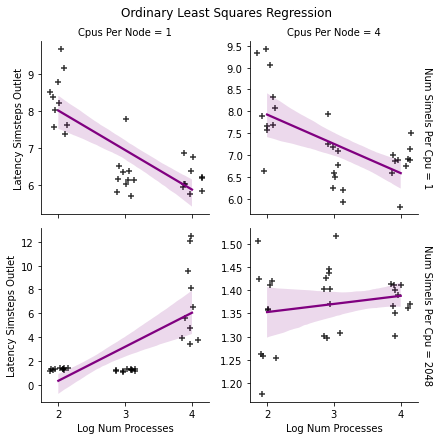

In [59]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Simsteps Outlet'] = (
    df_snapshot_diffs_copy['Num Pulls Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Simsteps Outlet',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=latency-simsteps-outlet+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per

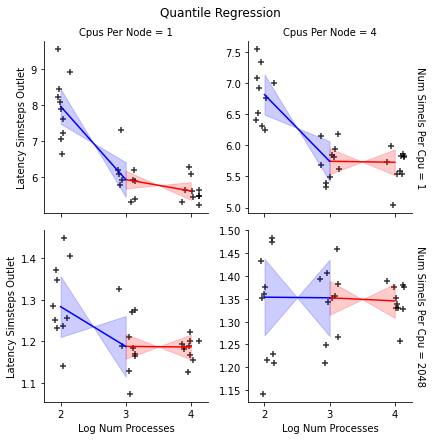

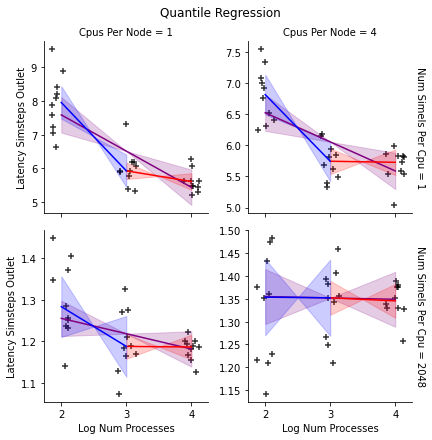

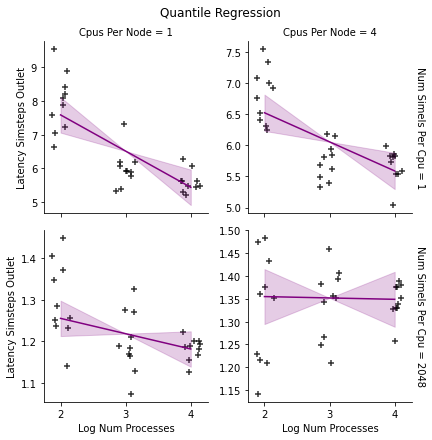

In [60]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Latency Simsteps Outlet',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Delivery Failure Rate

In [61]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Delivery Failure Rate'])
][[
    'Delivery Failure Rate',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Delivery Failure Rate  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                      NaN         3                           181.5  lac-050          0                   1              4            256
868                      NaN         4                           241.5  lac-050          0                   1              4            256
869                      NaN         5                           301.5  lac-050          0                   1              4            256
13477                    NaN         1                            60.5  lac-188          6                   1              4            256
13478                    NaN         2                           120.5  lac-188          6                   1              4            256
13479                    NaN         3                           180.5  lac-188          6                   1              4            256
13480                    NaN         4                           240.5  lac-188          6                   1              4            256
13481                    NaN         5                           300.5  lac-188          6                   1              4            256
52394                    NaN         2                           120.5  lac-046          9                   1              4             16
52395                    NaN         3                           180.5  lac-046          9                   1              4             16
52396                    NaN         4                           240.5  lac-046          9                   1              4             16
52397                    NaN         5                           300.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=delivery-failure-rate+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-failure-rate+ext=.png
teeplots/col=cpus-per-node+marker=+regressio

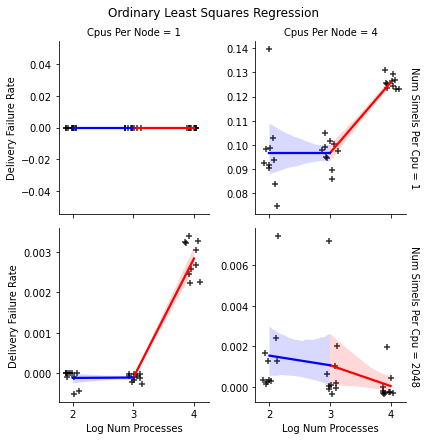

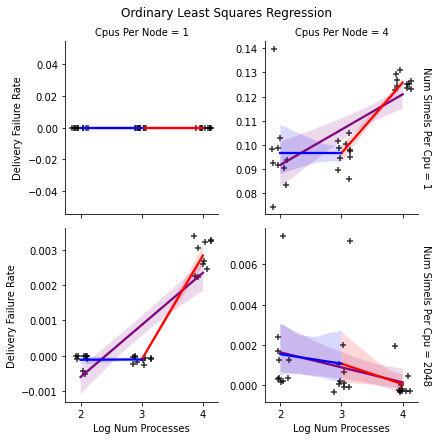

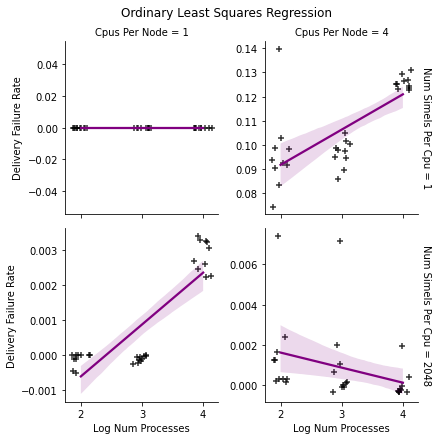

In [62]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Delivery Failure Rate',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/us

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=delivery-failure-rate+ext=.png


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/us

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-failure-rate+ext=.png


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:202: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))


teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=log-num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=log-num-processes+y=delivery-failure-rate+ext=.png


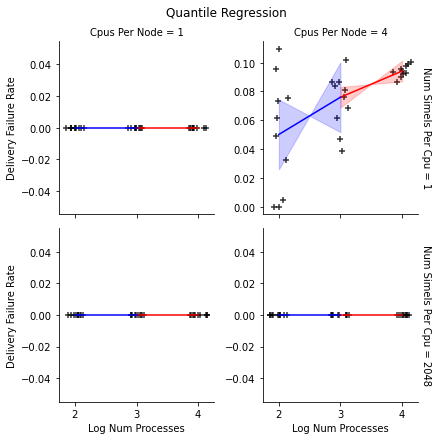

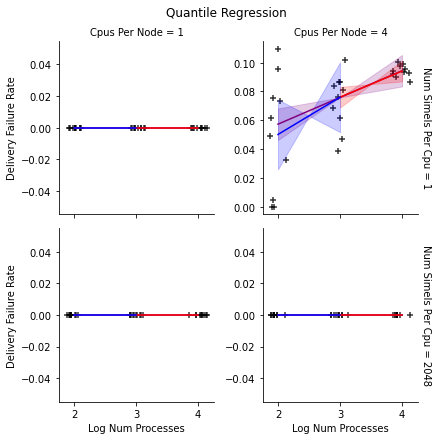

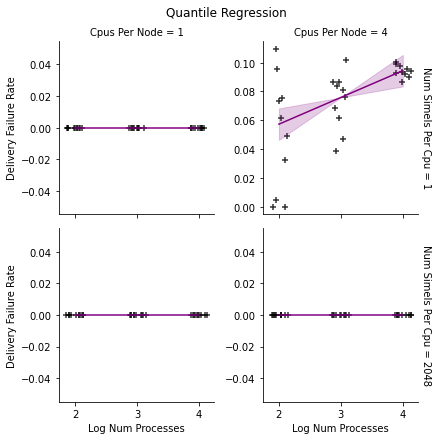

In [63]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Delivery Failure Rate',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Delivery Clumpiness

In [64]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Delivery Clumpiness'])
][[
    'Delivery Clumpiness',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Delivery Clumpiness  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                    NaN         3                           181.5  lac-050          0                   1              4            256
868                    NaN         4                           241.5  lac-050          0                   1              4            256
869                    NaN         5                           301.5  lac-050          0                   1              4            256
13479                  NaN         3                           180.5  lac-188          6                   1              4            256
13480                  NaN         4                           240.5  lac-188          6                   1              4            256
13481                  NaN         5                           300.5  lac-188          6                   1              4            256
52394                  NaN         2                           120.5  lac-046          9                   1              4             16
52395                  NaN         3                           180.5  lac-046          9                   1              4             16
52396                  NaN         4                           240.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=delivery-clumpiness+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-clumpiness+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordina

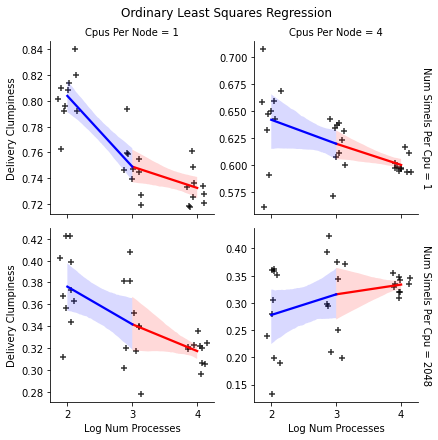

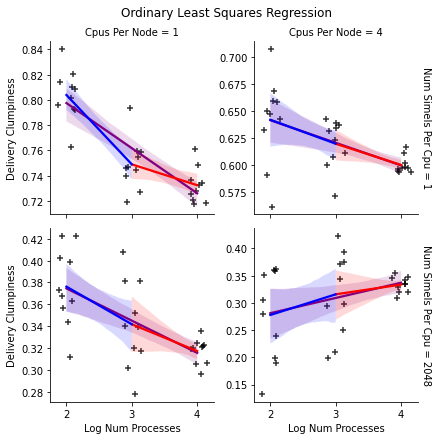

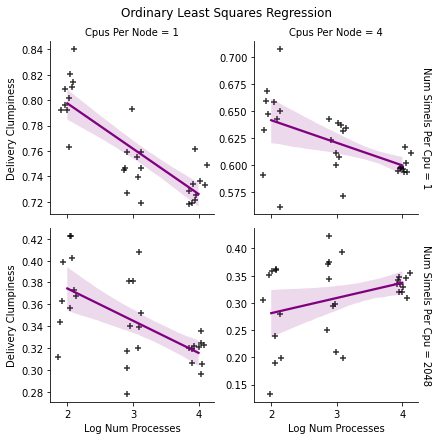

In [65]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Delivery Clumpiness',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=delivery-clumpiness+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-clumpiness+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=delivery-clumpiness+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=s

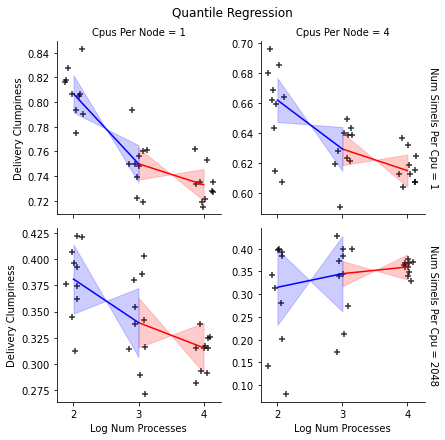

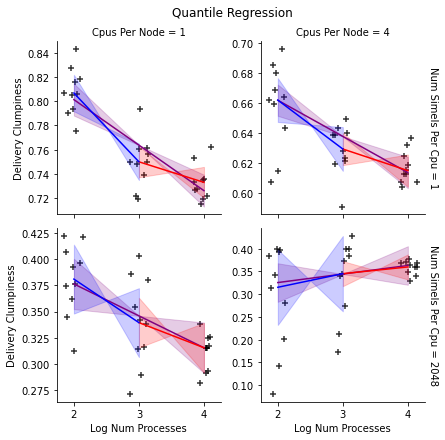

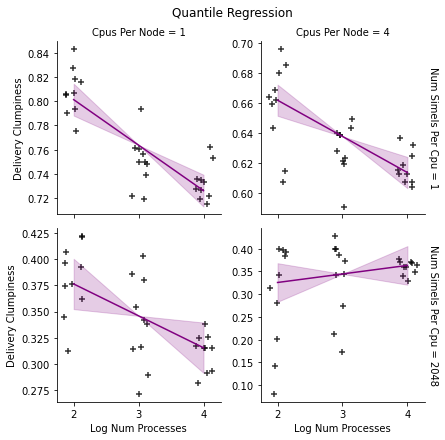

In [66]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Delivery Clumpiness',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Simstep Period Inlet (ns)

In [67]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Simstep Period Inlet (ns)'])
][[
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Simstep Period Inlet (ns)  Simstep Period Outlet (ns)  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                          inf                         inf         3                           181.5  lac-050          0                   1              4            256
868                          inf                         inf         4                           241.5  lac-050          0                   1              4            256
869                          inf                         inf         5                           301.5  lac-050          0                   1              4            256
13477                        inf                4.047297e+09         1                            60.5  lac-188          6                   1              4            256
13478                        inf                4.046799e+09         2                           120.5  lac-188          6                   1              4            256
13479                        inf                         inf         3                           180.5  lac-188          6                   1              4            256
13480                        inf                         inf         4                           240.5  lac-188          6                   1              4            256
13481                        inf                         inf         5                           300.5  lac-188          6                   1              4            256
52394                        inf                         inf         2                           120.5  lac-046          9                   1              4             16
52395                        inf                         inf         3                           180.5  lac-046          9                   1              4             16
52396                        inf                         inf         4                           240.5  lac-046          9                   1              4             16
52397                        inf                4.042569e+09         5                           300.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+r

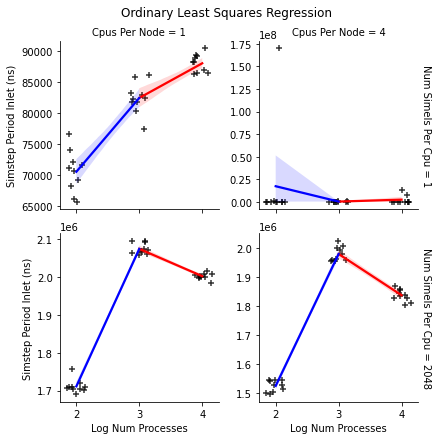

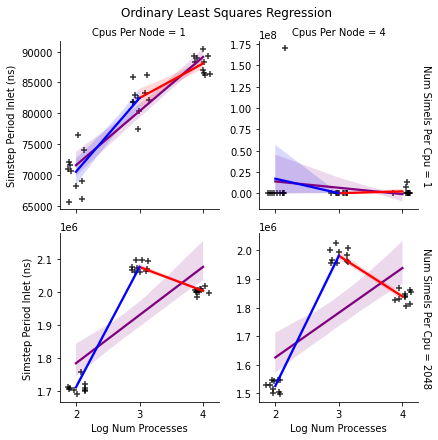

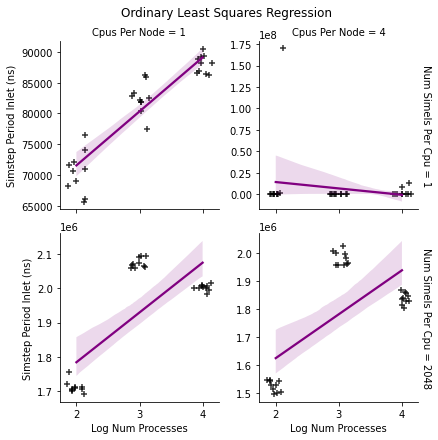

In [68]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs
# see listing of infs above
df_snapshot_diffs_copy['Simstep Period Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Puts Attempted'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Simstep Period Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-inlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per

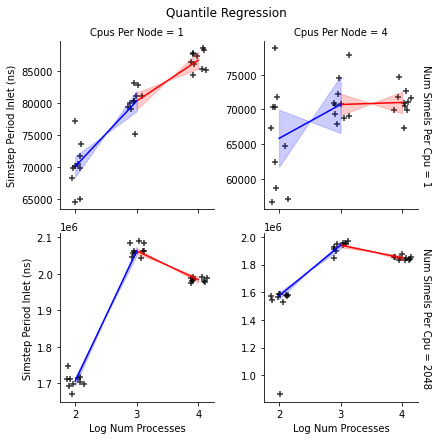

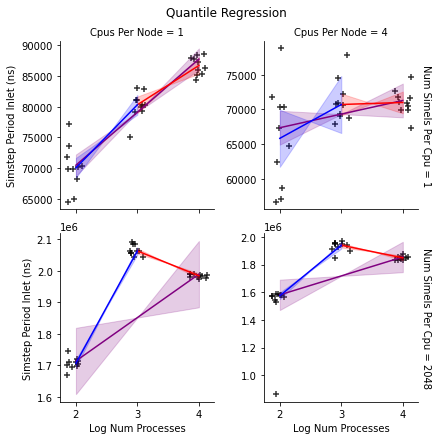

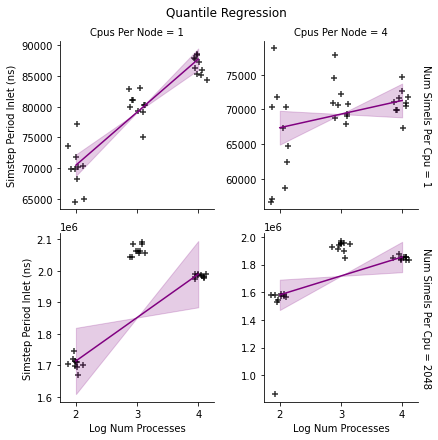

In [69]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Simstep Period Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


## Simstep Period Outlet (ns)

In [70]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Simstep Period Outlet (ns)'])
][[
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]

Simstep Period Inlet (ns)  Simstep Period Outlet (ns)  Snapshot  Runtime Seconds Elapsed Outlet Hostname  Replicate  Num Simels Per Cpu  Cpus Per Node  Num Processes
867                          inf                         inf         3                           181.5  lac-050          0                   1              4            256
868                          inf                         inf         4                           241.5  lac-050          0                   1              4            256
869                          inf                         inf         5                           301.5  lac-050          0                   1              4            256
13479                        inf                         inf         3                           180.5  lac-188          6                   1              4            256
13480                        inf                         inf         4                           240.5  lac-188          6                   1              4            256
13481                        inf                         inf         5                           300.5  lac-188          6                   1              4            256
52394                        inf                         inf         2                           120.5  lac-046          9                   1              4             16
52395                        inf                         inf         3                           180.5  lac-046          9                   1              4             16
52396                        inf                         inf         4                           240.5  lac-046          9                   1              4             16

teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marke

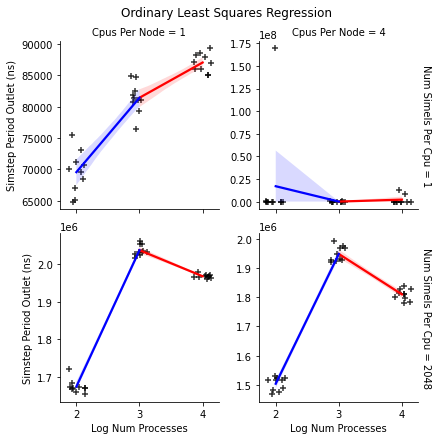

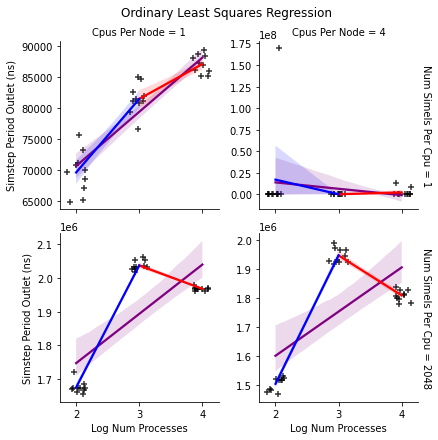

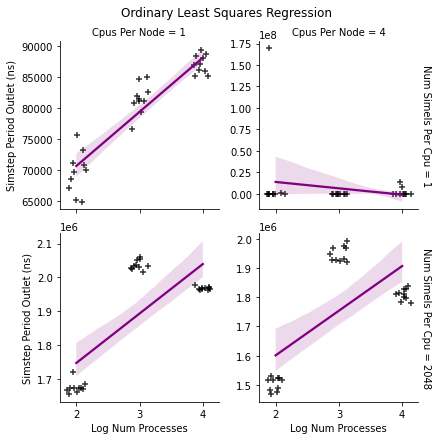

In [71]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs
# see listing of infs above
df_snapshot_diffs_copy['Simstep Period Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Pulls Attempted'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Simstep Period Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
    )

teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-split-unsplit-regression+x=log-num-processes+y=simstep-period-outlet-ns+ext=.png
teeplots/col=cpus-per-node+marker=+regression=quantile-regression+row=num-simels

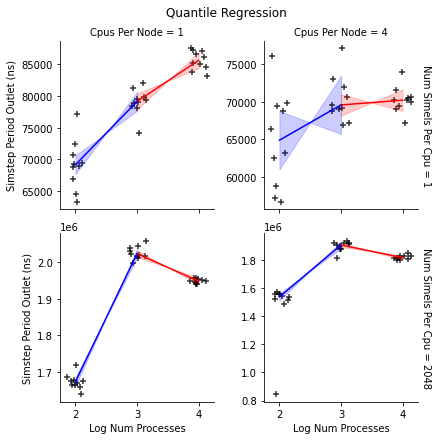

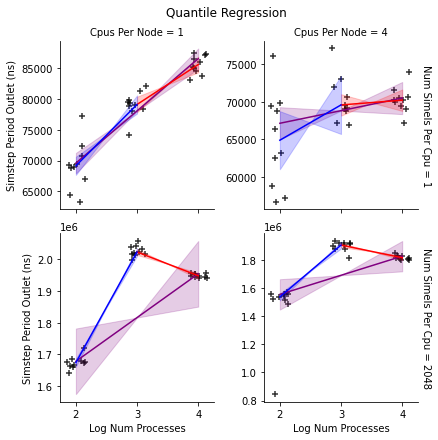

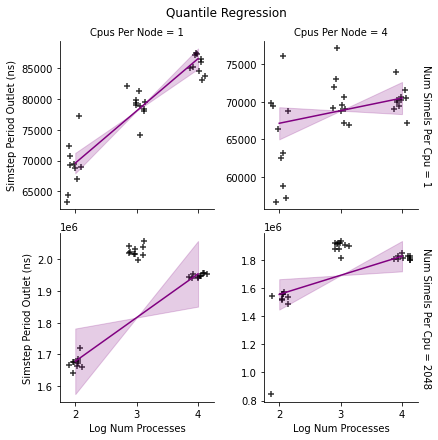

In [72]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})


for viz in facet_split_regression, facet_split_unsplit_regression, facet_unsplit_regression:
    tp.tee(
        viz,
        data=data,
        col='Cpus Per Node',
        row='Num Simels Per Cpu',
        x='Log Num Processes',
        y='Simstep Period Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


# Outlier Analysis

In [73]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 50)
    & (df_snapshot_diffs['Num Simels Per Cpu'] == 1)
]

Process Instance UUID  Snapshot  Async Mode  Num Nodes  Allocated Tasks Per Node  Cpus Per Node  Num Processes  Log Num Processes  Num Simels Per Cpu  Replicate  proc Hostname  Num Inlets  Num Outlets               Execution Instance UUID  Num Threads  Num Puts Attempted  Num Try Puts Attempted  Num Blocking Puts  Num Try Puts That Succeeded  Num Puts That Succeeded Eventually  Num Blocking Puts That Succeeded Immediately  Num Puts That Succeeded Immediately  Num Puts That Blocked  Num Dropped Puts  Num Reads Performed  Num Reads That Were Fresh  Num Reads That Were Stale  Num Revisions Pulled  Num Try Pulls Attempted  Num Blocking Pulls  Num Blocking Pulls That Blocked  Num Revisions From Try Pulls  Num Revisions From Blocking Pulls  Num Pulls Attempted  Num Pulls That Were Laden Eventually  Num Blocking Pulls That Were Laden Immediately  Num Blocking Pulls That Were Laden Eventually  Num Pulls That Were Laden Immediately  Num Try Pulls That Were Laden  \
4107   0d61819f-cd78-4ef6-9992-26be7569b2cb         3           3         64                         4              4            256                4.0                   1          0    49  lac-144           4            4  684e76c0-d4ce-44b8-a458-ba804f1eb65a            1               77236                   77236                  0                        44269                               77236                                             0                                44269                      0             32967               230879                       3532                     227347                  3532                    76958                   0                                0                          3531                                  0                76957                                  3531                                               0                                              0                                   3531                           3532   
14353  2cad7908-1e39-4fa2-98a6-da3f602f76b1         1           3         64                         4              4            256                4.0                   1          3   232  lac-187           4            4  88b4b04a-ca63-4efe-96b7-0bfb65cdf7ca            1              172630                  172632                  0                        88936                              172632                                             0                                88936                      0             83696               517153                       7314                     509839                  7314                   172385                   0                                0                          7313                                  0               172384                                  7313                                               0                                              0                                   7313                           7314   
14354  2cad7908-1e39-4fa2-98a6-da3f602f76b1         2           3         64                         4              4            256                4.0                   1          3   232  lac-187           4            4  88b4b04a-ca63-4efe-96b7-0bfb65cdf7ca            1              173052                  173052                  0                        91653                              173053                                             0                                91653                      0             81400               517848                       7861                     509987                  7861                   172616                   0                                0                          7861                                  0               172616                                  7861                                               0                                              0                                   7861                           7861   
14355  2cad7908-1e39-4fa2-98a6-da3f602f76b1       

In [74]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 50)
    & (df_snapshot_diffs['Num Simels Per Cpu'] == 2048)
]

Process Instance UUID  Snapshot  Async Mode  Num Nodes  Allocated Tasks Per Node  Cpus Per Node  Num Processes  Log Num Processes  Num Simels Per Cpu  Replicate  proc Hostname  Num Inlets  Num Outlets               Execution Instance UUID  Num Threads  Num Puts Attempted  Num Try Puts Attempted  Num Blocking Puts  Num Try Puts That Succeeded  Num Puts That Succeeded Eventually  Num Blocking Puts That Succeeded Immediately  Num Puts That Succeeded Immediately  Num Puts That Blocked  Num Dropped Puts  Num Reads Performed  Num Reads That Were Fresh  Num Reads That Were Stale  Num Revisions Pulled  Num Try Pulls Attempted  Num Blocking Pulls  Num Blocking Pulls That Blocked  Num Revisions From Try Pulls  Num Revisions From Blocking Pulls  Num Pulls Attempted  Num Pulls That Were Laden Eventually  Num Blocking Pulls That Were Laden Immediately  Num Blocking Pulls That Were Laden Eventually  Num Pulls That Were Laden Immediately  Num Try Pulls That Were Laden  \
6078   1347abb5-dc75-4256-b6e7-4743b0b82952         0           3        256                         1              1            256                4.0                2048          8   242  lac-417         186          186  d92d03ed-a353-41f4-8baa-a3024a53fc91            1               99911                   99911                  0                        61538                               99911                                             0                                61538                      0             38373               306459                      18844                     287615                 18844                   102296                   0                                0                         18844                                  0               102296                                 18844                                               0                                              0                                  18844                          18844   
6079   1347abb5-dc75-4256-b6e7-4743b0b82952         1           3        256                         1              1            256                4.0                2048          8   242  lac-417         186          186  d92d03ed-a353-41f4-8baa-a3024a53fc91            1              101382                  101382                  0                        53997                              101382                                             0                                53997                      0             47385               302665                      17605                     285060                 17605                   100976                   0                                0                         17605                                  0               100976                                 17605                                               0                                              0                                  17605                          17605   
6080   1347abb5-dc75-4256-b6e7-4743b0b82952         2           3        256                         1              1            256                4.0                2048          8   242  lac-417         186          186  d92d03ed-a353-41f4-8baa-a3024a53fc91            1              101885                  101885                  0                        47136                              101885                                             0                                47136                      0             54749               304149                      15075                     289074                 15075                   101383                   0                                0                         15075                                  0               101383                                 15075                                               0                                              0                                  15075                          15075   
6081   1347abb5-dc75-4256-b6e7-4743b0b82952       